# Trabajo Practico 2
## Procesamiento del lenguaje natural
- Profesores:
  - Alan Geary
  - Constantino Ferrucci
  - Dolores Sollberger
  - Juan Pablo Manson
- Alumno:
  - Bravi Eugenio
  - B-6600/1

## Carga de datos

In [1]:
!pip install gdown --quiet
!gdown https://drive.google.com/uc?id=1Rh6-OOTgWMXArBACLLWZ-yIpmNS5GPmE --quiet
!unzip -q datos_parks.zip -d ./

import os

ruta_directorio = "./datos/informacion"
datos_informacion: list[str] = []
nombre_archivos: list[str] = []
contenidos_unicos = set()

for nombre_archivo in os.listdir(ruta_directorio):
    ruta_archivo = os.path.join(ruta_directorio, nombre_archivo)
    try:
        with open(ruta_archivo, 'r', encoding='utf-8') as f:
            texto_completo = f.read()

        # Verificar si ya hemos visto este contenido
        hash_contenido = hash(texto_completo)
        if hash_contenido not in contenidos_unicos:
            # Guardar nombre del archivo y su contenido en la lista
            datos_informacion.append(texto_completo)
            nombre_archivos.append(nombre_archivo)
            contenidos_unicos.add(hash_contenido)
        else:
            print(f"Archivo duplicado omitido: {nombre_archivo}")

    except Exception as e:
        print(f"Error al leer el archivo {ruta_archivo}: {e}")

Archivo duplicado omitido: htp_videos_es_2.txt
Archivo duplicado omitido: htp_videos_es_6.txt


## Text splitting

Para la fragmentacion de texto se utiliza un fragmentador de texto por tokens en los transcriptos de videos ya que estos al tener un formato no estrucuturado no hay forma de fragmentarlos por delimitadores ni de forma  inteligentemente con un "semantic chunker", por eso se eligio una fragmentación por cantidad de tokens, donde luego de varias pruebas se decidio poner como tamaño de chunks 512 tokens, no mas porque si no el buscador BM25 siempre prioriza este tipo de archivos, y no menos porque si no son muy cortos, se pierde el contexto.

Para los archivos de texto estructurados se elige un fragmentador de texto semantico por sobre un fragmentador recursivo o por sobre un fragmentador de parrafos/oraciones ya que los textos cuentan con distintas estructuras y formatos. Como configuración del fragmentador sementacio, depues de varias pruebas, se decidio usar como tamaño minimo de chunk 2 tokens y como maximo 1024, permitiendo al modelo un buen margen de maniobra para agrupar las oraciones/parrafos. Como modelo modelo de embedding a diferencia del TP anterior en el que se utilizo "intfloat/multilingual-e5-large-instruct" en este trabajo, luego de analizar y comparar los distintos modelos de embeddings en el [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard) se decidio utilizar el modelo "Qwen/Qwen3-Embedding-0.6B" ya que este ofrece una mejor calidad de embeddings siendo un modelo levemente mas grande que el anterior, aunque el motivo principal por el que se lo eligio fue porque este modelo permite hacer embeddings de textos con mas de 1024 tokens (cantidad maxima de nuestros chunks) mientras que la cantidad maxima de tokens del modelo anterior es de 512, limitandonos en el tamaño de los chunks a generar y disminuyendo su calidad.

In [2]:
!pip install "chonkie[semantic]" numpy --quiet

import random
import re
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
from chonkie import SemanticChunker, AutoEmbeddings,TokenChunker
from chonkie.embeddings.sentence_transformer import SentenceTransformerEmbeddings

class Text_spliter:
  def __init__(self, max_chunk_size: int, min_chunk_size: int , embedding_model_name :str):
    self._max_chunk_size: int = max_chunk_size
    self._min_chunk_size: int = min_chunk_size
    self._embedding_model: SentenceTransformerEmbeddings = AutoEmbeddings.get_embeddings(embedding_model_name)
    self._semantic_chunker: SemanticChunker = SemanticChunker(
                        embedding_model=self._embedding_model,
                        mode="window",                              # Modo de comparación en ventana
                        threshold=0.7,                              # Umbral de similitud para agrupar oraciones
                        chunk_size=self._max_chunk_size,
                        min_chunk_size=self._min_chunk_size,
                        similarity_window=2,                        # Comparar con 2 oraciones anteriores
                        delim=['!','?','\n','\n\n'],                # Delimitadores para dividir oraciones
                        return_type="texts"
                      )
    self._token_chunker: TokenChunker = TokenChunker(
                                        chunk_size=512,
                                        chunk_overlap=0,
                                        return_type="texts"
                                      )


  def split_text(self, textos: list[str], nombre_archivos: list[str])->tuple[list[str], list[str]]:
    chunks = []
    origenes_chunks = []
    for i, text in enumerate(textos):

      if "videos" in nombre_archivos[i]:
        # Eliminar todo lo que esté entre corchetes, incluyendo los corchetes
        text = re.sub(r'$[^\]]*$', '', text)
        text_split = self._token_chunker.chunk(text)
      else:
        text = text.replace('\n \n','\n\n')
        # Eliminar URLs
        text = re.sub(r'https?://\S+', '', text)
        text_split = self._semantic_chunker.chunk(text)

      for chunk in text_split:
          chunks.append(chunk)
          origenes_chunks.append(nombre_archivos[i])
      self._plot_chunks(text_split, nombre_archivos[i])
      for j in range(min(3,len(text_split))):
        print( "\n" + "-" * 10 +"chunk: " + str(j+1) + "-" *10)
        print(nombre_archivos[i])
        print(text_split[j])
        print("-"*30)

    return chunks, origenes_chunks

  def get_embeddings(self, chunks: list[str])-> list[np.ndarray]:
    embeddings = self._embedding_model.embed_batch(chunks)
    return embeddings

  def _plot_chunks(self, chunks: list[str], nombre_archivo: str)->None:
    """
    Grafica la cantidad de palabras en cada chunk.
    """
    # Contar palabras en cada chunk usando split() básico
    word_counts = [len(chunk.split()) for chunk in chunks]

    # Generar gráfico
    plt.figure(figsize=(6, 4))
    plt.bar(range(1, len(word_counts) + 1), word_counts, color='lightblue')
    plt.title(f"Cantidad de Palabras por Chunk - Archivo: {nombre_archivo} ({len(word_counts)} chunks)")
    plt.xlabel("Número de Chunk")
    plt.ylabel("Cantidad de Palabras")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(range(1, len(word_counts) + 1))
    plt.tight_layout()
    plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 625.4/625.4 kB 22.7 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/9.71k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

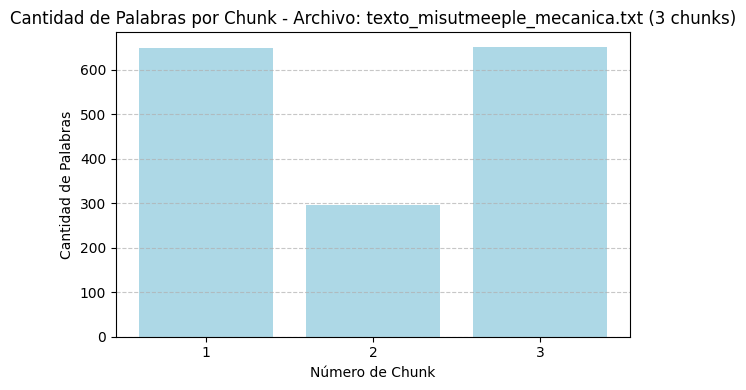


----------chunk: 1----------
texto_misutmeeple_mecanica.txt
PARKSes un diseño en el que los jugadores representan a excursionistas que visitarán diversos parques nacionales. A lo largo de cuatro rondas, cada jugador gestionará dos peones que se desplazarán sobre un track de casillas, teniendo en cuenta que un excursionistas no podrá detenerse en una casilla ocupada (aunque cada jugador dispone de una oportunidad de romper esta regla en cada ronda) que proporcionan recursos, permiten conseguir cantimploras (que cuando se obtiene agua, se pueden rellenar para activar sus efectos), comprar equipamiento (que proporciona efectos permanentes) o visitar parques (teniendo que pagar los recursos indicados en la carta disponible en el suministro). Cada jugador dispone de un objetivo secreto que bonifica en función de los parques visitados.
Empecemos por losRecursos. Durante la partida los jugadores podrán obtener fichas de cuatro tipos de recursos: agua, sol, bosque y montaña. Adicionalmente te

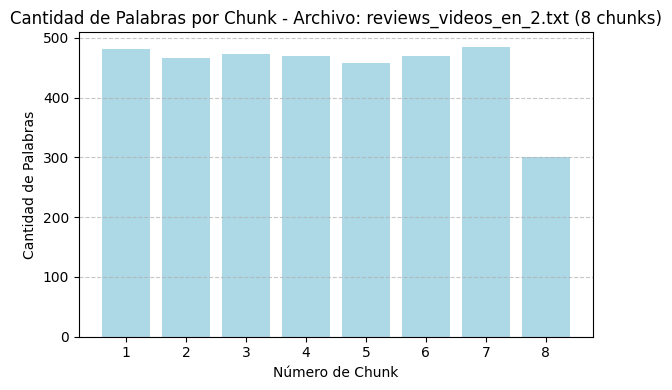


----------chunk: 1----------
reviews_videos_en_2.txt
hey there I'm Joel my name is Ryan we're about to play parks this is my first time playing this game and if it's also your first time you may want to check out our how to play video by hitting that little eye right above my head before we get going here let's jump in all right we got the board all set up here we have everything out here in the camera except our tokens are off camera to make a little room and we are ready to go and Joel's first player alrighty I am going to take my first action to go to this mountain which means I get this I believe and this it is good to be the first player maybe you should have gone hiking last week did you hiking last week I did about a week and a half ago oh well in that case no like I went yesterday I get the water from the weather apparents gonna go right there I get two Sun I get two Sunshine from there and your turn okay I'm gonna come here and give your guy a little kick and use my campfire 

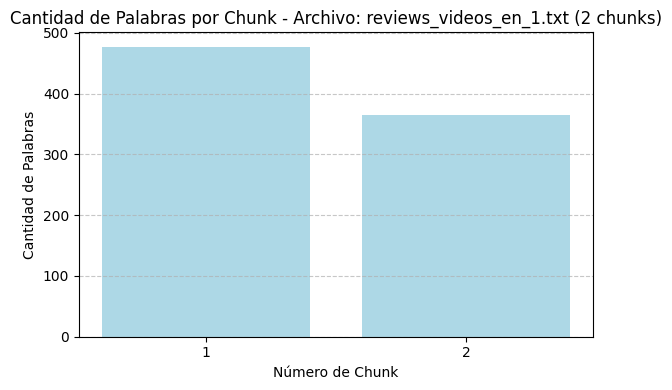


----------chunk: 1----------
reviews_videos_en_1.txt
welcome back to the channel everyone today I'm going to be doing my review of parks now Parks is a set collection game this game's been out for quite some time it's been very popular um so in this game you're playing as the as hikers here you have your little these hiker meeples here which are really cool and you're gonna have these little Trails here laid out Acro along the board along the board here but what you're doing is you're going to these different locations and collecting the resources that are on these spots of course and you know you competing against other players there's also Soul mode uh the components on this game are freaking beautiful especially with the Arkansas as you're collecting these resources you're using those resources to visit there's a different national parks that are laid off laid across the board here and the art on them is just again stunning fantastic everything component wise in this game is is bea

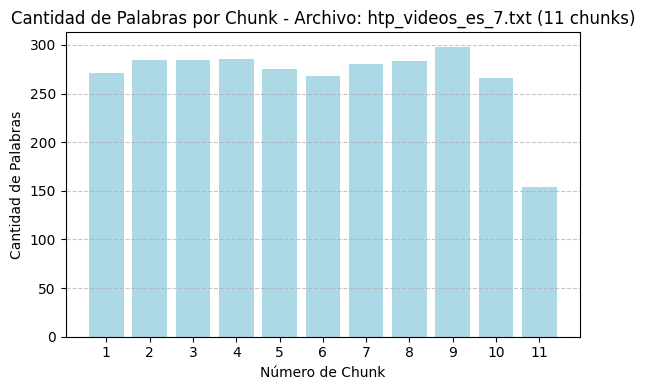


----------chunk: 1----------
htp_videos_es_7.txt
[Música] buenas jugones bienvenidos a un nuevo vídeo de cómo se juega a marks un juego de 15 jugadores compartía vecino aproximadamente unos 60 minutos y a partir de 10 años lo edita en castellano atrás y se queda aquí le mandamos un saludo y su autor esto me pasó también en la en la presentación del juego pero creo que venía aquí unos créditos si no me equivoco y aquí tenemos el diseño del juego es henri a lugo y desarrollo de matos leer más jennifer graham match kylie qué y la ilustración es de clickair y much tops schüller pues ya sabéis que mi idiomas dejan mucho que desear así que por favor perdonarme todos esos nombres que he dicho pero bueno toda esta gente son los creadores de este parque bueno de que baa resumidamente parte bueno somos una excursionistas que vamos a ir visitando diferentes parques naturales en este caso de eeuu que son reales vamos a ir avanzando a lo largo de un año de las cuatro estaciones vamos a ir avanzand

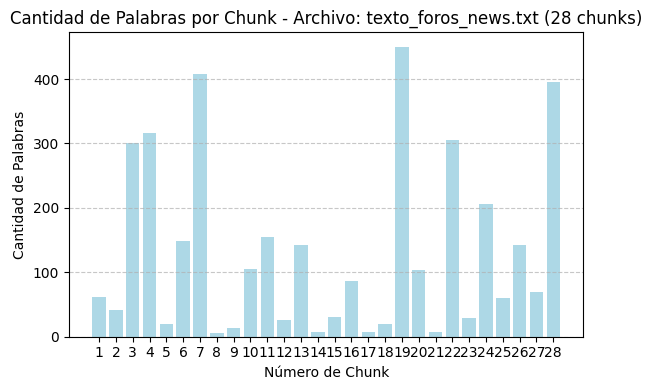


----------chunk: 1----------
texto_foros_news.txt
Ein Nachdruck für die deutsche Ausgabe war ursprünglich für November angekündigt, laut Homepage von Feuerland Spiele steht nun 3/2021 als neuer Termin. Gibt es dazu weitere Infos warum?
I agree.

An optimist says the glass is half full.
A pessimist says the glass is half empty.
An engineer asks why the glass was twice as large as it needed to be.

------------------------------

----------chunk: 2----------
texto_foros_news.txt
We hope it will arrive internationally as soon as possible too. Trails is still set to arrive sometime this summer for those outside the US.
Awesome, very exciting! PARKS is one of my all time favorite games, can't wait to get this!
------------------------------

----------chunk: 3----------
texto_foros_news.txt

Finally, an expansion to make the wildlife better in the base game without the need to introduce extra complexity from the nightfall! I would consider using this expansion with the base game when teach

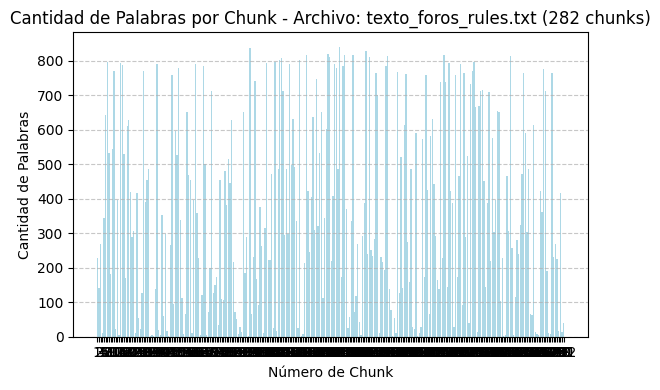


----------chunk: 1----------
texto_foros_rules.txt
There should be only 3 Parks face up available.
4) Can I choose the park reservation function as the last Hiker at the end of the season if I do not have a boring amount of resources? Or even if I have resources, can I not buy a reserved park?
Correct
Hi Folks,

We played a bunch today. At the beginning, one player indicated that when visiting a park, any two tokens from one's personal supply can be exchanged for one other non-wildlife token from the general supply, and this newly acquired token can then be used to pay for that park visit.

I looked through the rulebook later but couldn't find this rule.

I think how we played was a house rule (likely inspired from Wingspan - it's all a blur!) and not an official rule but wanted to confirm in case I'm just constantly missing it in the rulebook!

Thanks!
Wow, I would never think to read it that way. Every worker-placement game that I've ever played with a space to claim the first playe

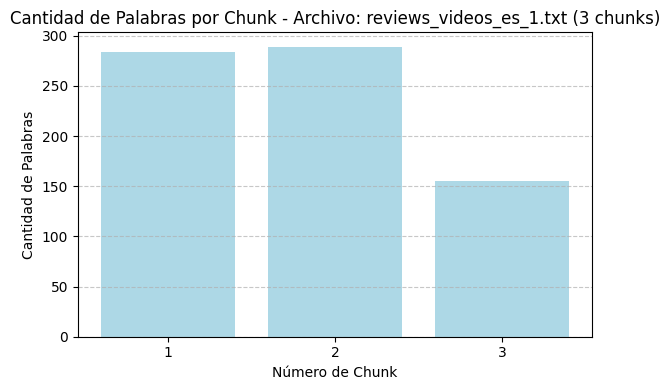


----------chunk: 1----------
reviews_videos_es_1.txt
y ahora pasamos a parks que hay Master games en este caso lo trae España games unas 5 jugadores 10 o más años 30 60 minutos 509 parks Henry Audi esta belleza de juego que lo veis en caja pequeña tiene mucha calidad mucha cantidad de componentes y es muy bonito el juego porque voy cogen Nova habrán pedido permiso ilustraciones ilustraciones de los diferentes parques que hay en los Estados Unidos sabéis que Estados Unidos pues es muy grande y tiene muchos parques y bueno han hecho esto que me parece una maravilla porque así conoces de una manera diferente Que seguro que hay alguien que tomará fotos irá a los parques y en base a este juego seguro pero bueno y bueno una manera diferente como de conocer otras parques nacionales maravillosos qué hacemos somos senderistas cada jugador tiene sus dos senderistas de un mismo color en el que vamos avanzando a lo largo de la partida por un Track que bueno cada turno va a ir creciendo creciendo 

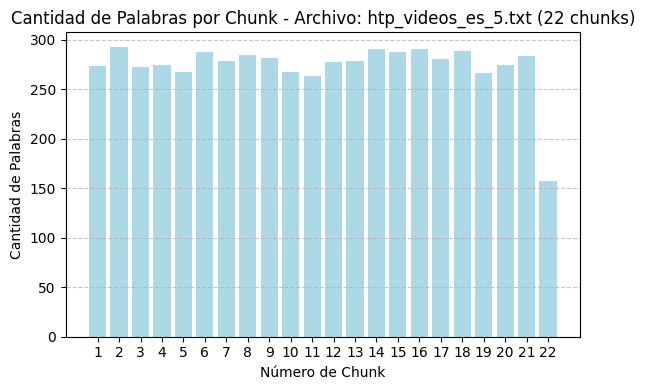


----------chunk: 1----------
htp_videos_es_5.txt
buenas hoy os voy a enseñar a jugar al parque juego diseñado por henry auto von que contiene más de 50 ilustraciones sobre parques naturales de eeuu además también os voy a enseñar la expansión night pool y todo esto lo vamos a ver en el simulador espero que os guste el vídeo entonces vamos a montar una partida para dos jugadores pues lo primero que vamos a hacer es mezclar el marco de parques aéreo y robar tres cartas boca arriba estas cartas de aquí son parques naturales como habéis visto con sus ilustraciones y lo que nos va a hacer nos van a dar puntos de victoria al final de partido ese es el número de abajo a la izquierda que veis entonces luego lo vemos más en detalle y lo siguiente que hacemos es lo mismo con el mazo de equipo vamos y robamos tres bocas arriba también bajo de equipo veremos que luego en el turno del jugador hay oportunidades de comprar este equipo puede ser un filtro de agua una brújula hay varios equipos lo sig

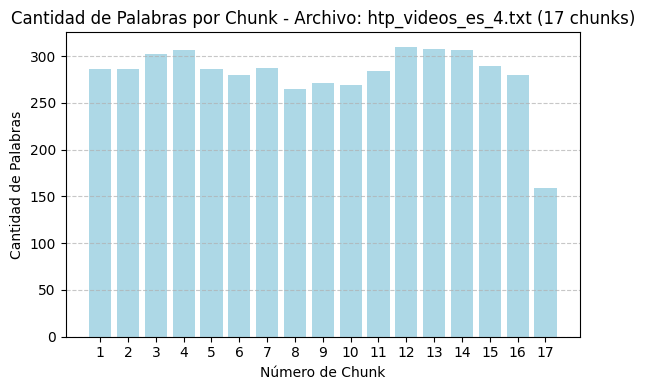


----------chunk: 1----------
htp_videos_es_4.txt
hola hola pues el día de hoy les vamos a enseñar este hermoso juego que se llama parks es un juego de 1 a 5 jugadores y realmente aunque dice que tarda de 40 a 70 minutos yo creo que tarda como más o menos una media hora ya cuando tienes experiencia la primera partida mejor si te va a tomar unos 50 minutos tal vez pero ya después se ve muy muy ag es un juego muy bonito muy fácil de explicar y muy fácil de entender muy fácil de jugar obviamente y aunque lo juego dos veces ese juego me gustó muchísimo tenemos la expansión y esta se la voy a explicar en otro vídeo hoy no vamos a consultar únicamente en el juego base bien pues realmente la primera parte del set op es básicamente esta área del aborto y básicamente lo único que hay que hacer es pues hay que revolver los parqués y mostramos tres vamos a revolver las cartas de equipo y vamos a mostrar tres vamos a revolver las cartas de temporadas o de xixón y vamos a revelar una y vamos a revo

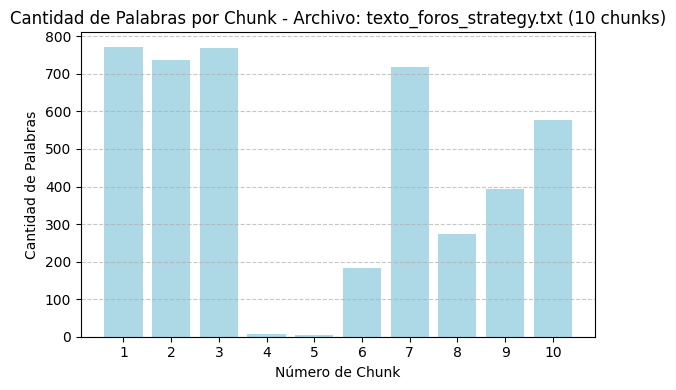


----------chunk: 1----------
texto_foros_strategy.txt
There seem to be two running ideas on the Parks' forums. One is that the gear is underpowered and another that it is overpowered:


That thread is on a particular gear card (Park Pass), but the discussion talks about other gear that might counteract the effects of the Park Pass.
We just got the game and have played 3 times so far at 2P. First game was really just learning. There wasn't much of any strategy going on, and the Gear cards weren't anything great.

Second game, I ended up getting a few really useful Gear cards early on, so I thought, "What the heck. Let's go for it." I really thought I was going to loose because I was so far behind as far as visiting parks goes going into round 3, but I ended up being able to purchase 2 Parks in round 3 and then 5 Parks in round 4 for the win.

Third game I thought, "Well, it worked so well last time, let's try again." This time my opponent also went for a few gear cards, but no where ne

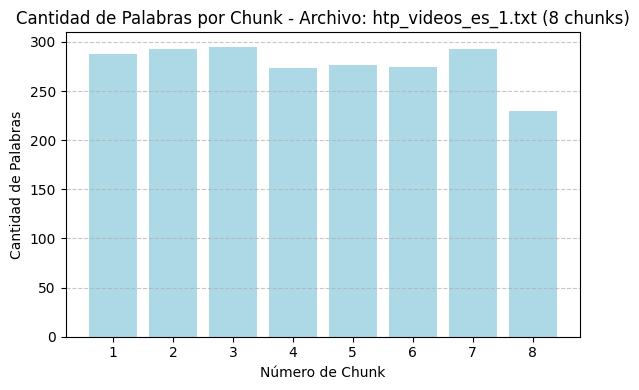


----------chunk: 1----------
htp_videos_es_1.txt
bienvenidos al mes amorfosis Hoy les vamos a explicar Cómo transformar su mesa en una visita por los parques nacionales de Estados Unidos con el juego parks es un juego de Uno a cinco jugadores en el cual seremos excursionistas que van a intentar visitar la mayor cantidad posible de parques nacionales y vamos a intentar que esa experiencia sea lo más satisfactoria posible disfrutando no solo del parque sino también del camino quieren visitarlo vean como jugar para configurar el Parts primero vamos a extender el tablero en el tablero vamos a obviamente vamos a ver barajado todos estos estos distintos mazos odex aquí va a ir el mazo de parques y vamos a revelar tres que van a estar disponibles los primeros tres que van a estar disponibles tenemos este Mazo que es el que va aquí que es el de los en el equipo también vamos a arreglar tres tenemos esta baraja que son los las cantimploras que van a ir aquí y le vamos a ver entregado una a un 

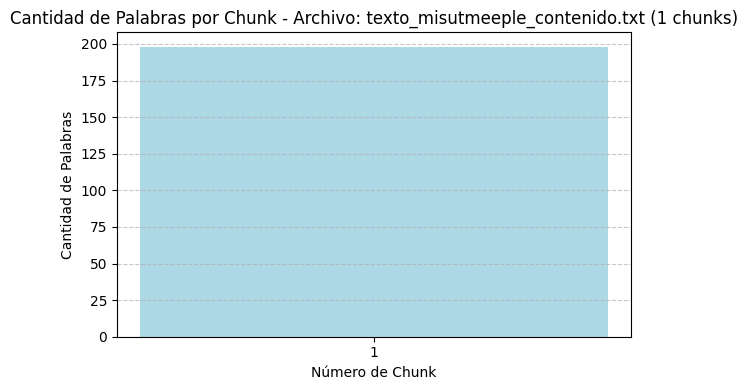


----------chunk: 1----------
texto_misutmeeple_contenido.txt
Dentro de una caja de cartón de dos piezas (tapa y fondo), de dimensiones 21,5×21,5×6 cm. (caja cuadrada mediana similar a LUNA Capital), encontramos los siguientes elementos:
- Tablero Principal (de cartón)
- 2 Estuches para Recursos (de plástico)
- 48 Cartas de Parque (70×120 mm.)
- 74 Cartas Pequeñas (50×75 mm):10 Cartas de Estación12 Cartas de Año36 Cartas de Equipamiento15 Cartas de Cantimplora9 Cartas de Evento
- 10 Cartas de Estación
- 12 Cartas de Año
- 36 Cartas de Equipamiento
- 15 Cartas de Cantimplora
- 9 Cartas de Evento
- 10 Losetas de Zona (de cartón)
- Loseta de Inicio (de cartón)
- Loseta de Fin (de cartón)
- 10 Excursionistas (2 de cada color) (de madera)
- 5 Losetas de Campamento (de cartón)
- Loseta de Cámara (de cartón)
- Ficha de Jugador Inicial (de metal)
- 102 Fichas de Recursos (de madera):15 Fichas de Bosque15 Fichas de Montaña30 Fichas de Sol30 Fichas de Agua15 Fichas de Vida Salvaje
- 15 Fichas de

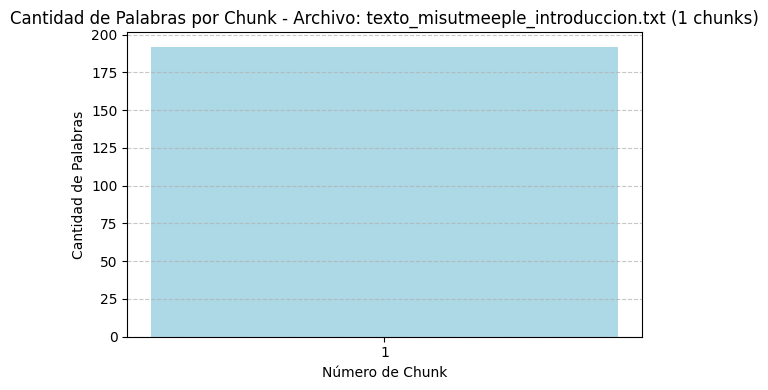


----------chunk: 1----------
texto_misutmeeple_introduccion.txt
Visita los parques nacionales de Estados Unidos. Poneos en la piel de dos excursionistas y recorred las rutas de los parques. Cada viaje será una experiencia única gracias al equipo que llevéis y a las fotografías que toméis por el camino. ¡Disfrutad de un viaje inolvidable!
Así se nos presentaPARKS, un diseño de Henry Audubon (TRAILS, Kingswood). El juego fue publicado por primera vez en 2019 por Keymaster Games en una versión en inglés. De las ilustraciones se encarga el estudio Fifty-NinePARKSPrint Series.
Se encuentra publicado en español por Tranjis Games (hay cierta dependencia del idioma en las cartas de equipamiento). Permite partidasde 1 a 5 jugadores, con unaedad mínima sugerida de 10 añosy unaduración aproximada de entre 30 y 60 minutos. Elprecio de venta al público es de 49,95€. Para esta reseña se ha utilizado una copia de la versión en inglés de Keymaster Games.
Importante: si ya conoces el juego y/o sólo te

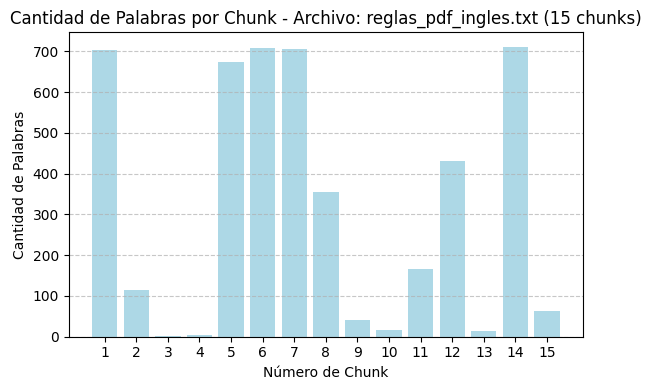


----------chunk: 1----------
reglas_pdf_ingles.txt
 celebrates America’s national parks and features art from the 
Fifty-Nine Parks Print Series. Players take on the role of two hikers who 
will trek trails to see sites, observe wildlife, take photos, and visit national 
parks over the course of the game.RULEBOOK VERSION 1.1
HENRY
AUDUBONWatch how to play at
PARKSGAME.COMPARKS •  Shuffle all the Park cards face down to 
form the Parks deck. Deal three face up into the top 
slots of the board and place the deck onto the Parks 
deck area on the top right of the board.
 GEAR •  Shuffle all the Gear cards face down to 
form the Gear deck. Deal three face up into the bot-
tom Gear slots on the board and place the deck onto 
the Gear deck area on the bottom right of the board.BOARD & RESOURCES • Place the board in between all players. Place 
the two token trays to the left and right of the board where they are easily 
within reach of the players and return their lids to the box. Each tray 


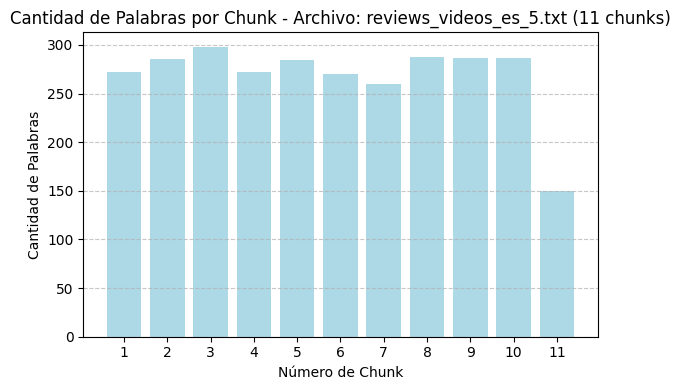


----------chunk: 1----------
reviews_videos_es_5.txt
[Música] qué tal amigos bienvenidos de nuevo a la estantería 83 espacio dedicado a los juegos de mesa yo soy eduardo gonzález y yo capital y hoy hablamos de parks bueno pues tenemos aquí desplegado un poco el setup para los jugadores aunque para más jugadores también sería igual lo aplicamos un poquito que tenemos por aquí pues cada jugador va a recibir una especie de hoguera de doble cara por un lado transcendido y por otro estar apagada una cantimplora que la cojera y le dará la vuelta y dos cartas de año y cogerá una de las dos otras volverá de la pila y ésta permanecerá oculta que son los objetivos que al final de la partida pues nos darán puntos y lo haremos así ocultas un jugador será el primer jugador que es el inicial que bueno pues se llevará este esta cosita metálica está el triángulo metálico y el jugador que nos inicial pues se va a llevar la cámara de fotos que le otorgará ventajas bueno aquí tenemos pegado el tablero n

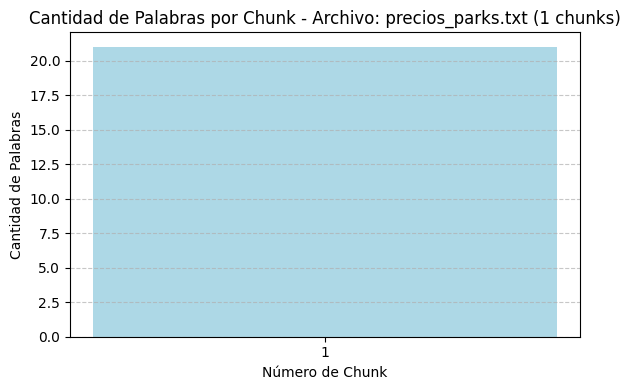


----------chunk: 1----------
precios_parks.txt
$65.00 at Noble Knight Games 
$63.99 at K&B Hobbies and Games 
$44.99 at Boardtopia 
$44.99 at Coupled Games 
$28.29 at eBay 

------------------------------


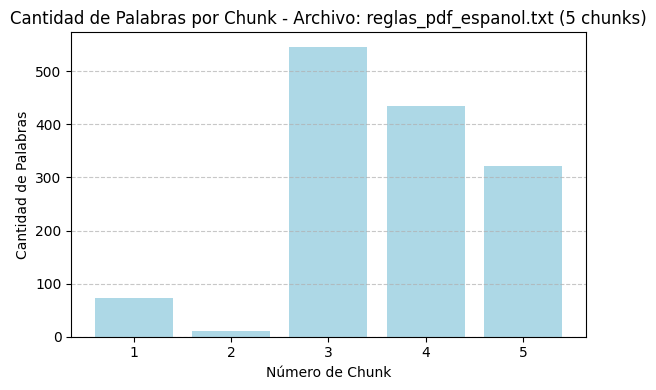


----------chunk: 1----------
reglas_pdf_espanol.txt
¿Te son útiles mis contenidos? Si puedes considera aportar con un donativo al PayPal jugandoconketty@gmail.com  

 Parks   
Diseñado por  Henry Audubon  
1-4 jugadores / 30-60 minutos / 10+ 
Reglas a la JcK por Ketty Galleguillos (jugandoconketty@gmail.com / www.jck.cl )  
Los jugadores toman el rol de dos senderista s que a lo 
largo de un año recorrerán  los parques de Estados 
Unidos, donde admirarán el paisaje, observarán la vida 
silvestre  y tomarán fotos.  

PREPARACIÓ N 

------------------------------

----------chunk: 2----------
reglas_pdf_espanol.txt

• Coloca el tablero  en el  centro de la mesa.  

------------------------------

----------chunk: 3----------
reglas_pdf_espanol.txt
• Coloca una bandeja de componentes  a cada lado.  Los 
componentes son limitados . 
• Baraja las cartas de parque  y colca el mazo  en el 
espacio superior derecho del tablero . Revela las  3 
cartas superiores para formar la oferta.  
• Bara

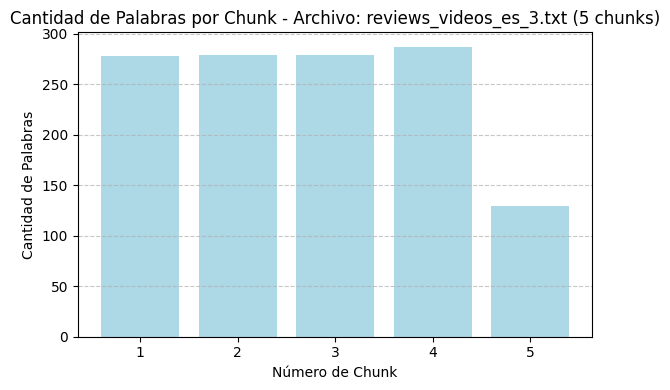


----------chunk: 1----------
reviews_videos_es_3.txt
hola muy buenos días y bienvenidos a nuestros vídeos de hoy han tenido bajar un poquito la reseña de barx un juego de la editorial tranquis es un juego de uno a cinco jugadores dudo que el juego sea bien no es demasiado rápido es bastante sencillo una vez casi pero con un jugador o cinco para por un jugador quieres que haya un jugador lo que tiene es unas cartas extra para hacer la partida no lo he probado no sé si es aconsejable si os gusta dar caminatas por los parques como a mí tiene fotografías muy bonitas de parques a nivel de animales eso es bonito y es muy bonito porque a partir de 10 años tiene un poquito de dificultad pero no mucha esto sería un esplendor diferente pero diez años me sorprendió por algo debe ser por la dificultad pero debajo de grande tienen que ser mayores yo creo que con menos años podría jugar el malo bueno supongo que ellos lo tienen estudiados lo miramos la pescadilla animalitos la caja se ve cbs volver

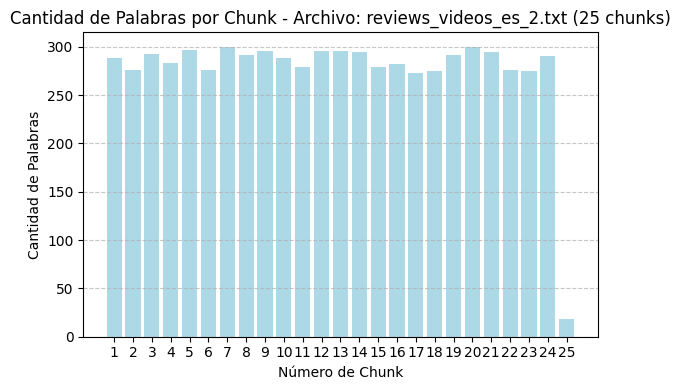


----------chunk: 1----------
reviews_videos_es_2.txt
estimada gente este descuento 20 y hoy cogemos la mochila la cantimplora porque vamos a visitar los parques más recios hicimos de eeuu hoy hablamos de y de su expansión night fall [Música] un juego de henry auto moon que en español tenéis publicado por tranquis games esto es un juego para 10 años en adelante partidas de 60 minutos y de 1 a 5 jugadores y aquí tenéis es uno de los juegos más esperados de trànsits con uno de los juegos más bonitos que vais a ver unos juegos que teníamos una canal lo cante a tener si te digo que esté aquí es un euro game de gestión de recursos y colocación de trabajadores estuvieras pues esto hay uno no millones por esto es un euro game mejor canción de trabajadores y gestión de recursos pero que es muy bonito y que tiene que haber que siguen cuando mecánica esos dos neuro game de colocación de trabajadores que van avanzando por un track considerado recursos son los recursos visitan unos parques lo para

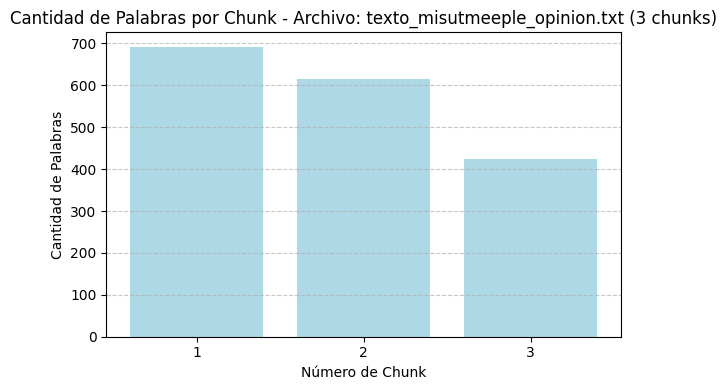


----------chunk: 1----------
texto_misutmeeple_opinion.txt
Hoy analizamos uno de esos juegos que llaman poderosamente la atención simplemente con ver su portada y su despliegue. Y es que es imposible no verse atraído por estePARKS. Un juego que desde ya os digo que es de esos diseños de corte familiar, amable y con el que se busca pasar un rato agradable.
Lo malo de este tipo de diseños es que muchas veces pecan de simplicidad en lo que a toma de decisiones se refiere, lo que acaba convirtiéndolos en un envoltorio bonito más que en otra cosa. Vamos a comprobar si este es uno de estos casos.
EnPARKSnos convertiremos en excursionistas que visitan los distintos parques naturales de Estados Unidos. Nuestro objetivo es hacer acopio de vivencias que tengan un mayor valor. Vivencias representadas con fotografías tomadas a lo largo de los viajes, recuerdos de los parques visitados y una carta de objetivo que cada jugador intentará completar lo mejor posible.
Mecánicamente nos encontramos con 

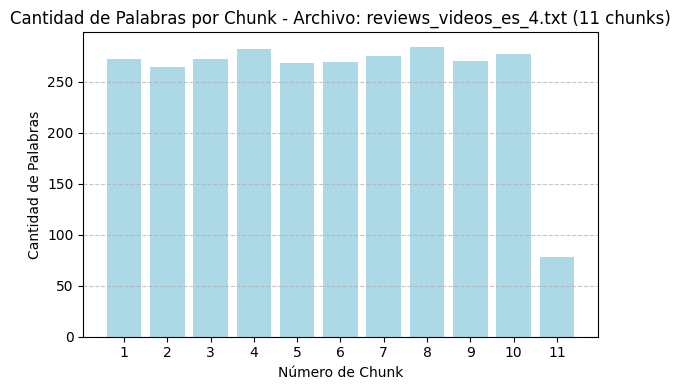


----------chunk: 1----------
reviews_videos_es_4.txt
hola bienvenidos al canal hoy os traemos parks un juego de colección de sets y colocación de trabajadores que utiliza un tablero modular fue diseñado por henry audubon e ilustrado por fifty nine park sprint series el juego fue publicado por primera vez en 2019 por key master games mientras que la versión en español corre a cargo de trans games en parks los jugadores se convierten en excursionistas cuyo objetivo es tener la mayor cantidad de puntos que obtendrán visitando parques haciendo fotos y cumpliendo los objetivos personales es un juego de 1 a 5 jugadores está recomendado para mayores de 10 años y tiene una duración de entre 30 y 60 minutos por partida vamos a ver de qué trata este parque si ya conoces parks y quieres descubrir su expansión consulta nuestro vídeo de nightfall donde te explicamos las nuevas mecánicas y cambios respecto al juego original vamos ya con la preparación de la partida primero habrá que colocar el tabl

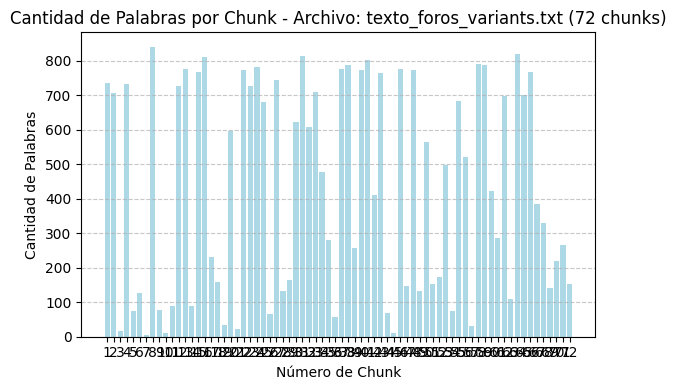


----------chunk: 1----------
texto_foros_variants.txt
I don't find that canteen card (nor any other canteen card for that matter) to be broken, but if it's really so objectionable to you, just remove it from the game. Why attempt to nerf it by creating a house rule? Just get rid of it and move on.
You bet. Happy to clarify!
It is hybrid set-up. It is set-up mostly like an all-human 3-player game, but you'll move RR using the gear cards, which is how the gear cards come out onto the main board. And no events.
You could also use a Wildlife to represent the new Bison rule on Parks cards (or if you think you'll run out of WL then a sunshine or unused hiker, or the Bear from Trails if you own that)
These are so awesome!! How can I print them on the right card stock and with the matching backs so they blend in with the rest of my Parks cards?
Sunset Over Water
* Module 3: TRAILS Hikers (using alternative system for “Reserve a Park”) [2-4 Players] *

- Each player begins the first season, in

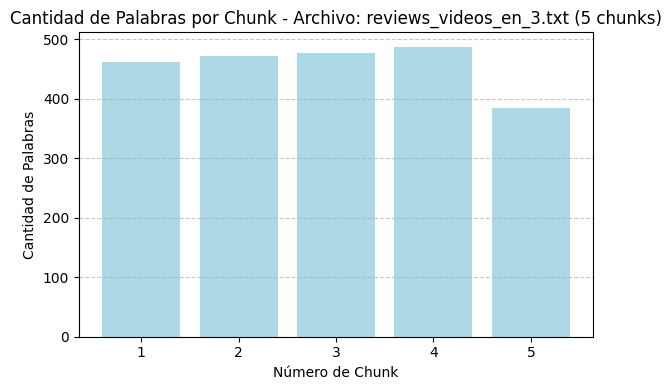


----------chunk: 1----------
reviews_videos_en_3.txt
hello welcome to bad at board games he's bad at working i'm lumberjack brad and i'm aura and i guess you picked her side that's not very nice of you [Laughter] we're here to talk to you about parks if you've seen our top board games for couples you will notice spoilers that that was on this list and now we're going to talk about this so this is from key master games by i'm going to get it wrong henry audubon and the artwork is done by a lot of different artists so that's probably one of the reasons it's such a looker so what do you think about how this game looks i love the way it looks um i like all the little drawings on all the little cards i'm a big fan of the national parks i would love to visit them all and i'm working very very slowly towards it and i just like how different each of them are and they're unique to the parks i feel like it captures them in a really colorful wonderful way um and the little tokens they're nice th

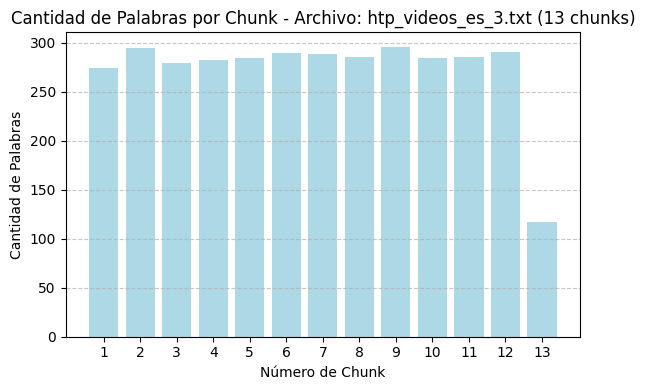


----------chunk: 1----------
htp_videos_es_3.txt
[Música] hola que tal bienvenidos a tono y acción hoy vamos a echar un vistazo a pax vamos a ver para empezar vamos a colocar el tablero encima de la mesa y las bandejas de recursos las ponemos un a cada lado o en cualquier parte para que tengan acceso todos los jugadores a ellas escogemos las cartas de parque que son las grandes sacaremos al azar después de barajar las tres las pondremos en las tres posiciones centrales y el resto del mazo lo dejaremos aquí si os fijáis en el tablero tenemos el simbolito que corresponde a cada tipo de carta aquí serían las cartas de equipo que después de barajar se colocan aquí el mazo y sacaríamos tres que son las que vamos a poder adquirir durante la próxima ronda todas estas cartas en el momento que alguien que algún jugador se lleve alguna se rellenará el hueco con una nueva carta luego tenemos las cartas de cantimplora que también se baraja y se colocan en su posición también viene marcada en el t

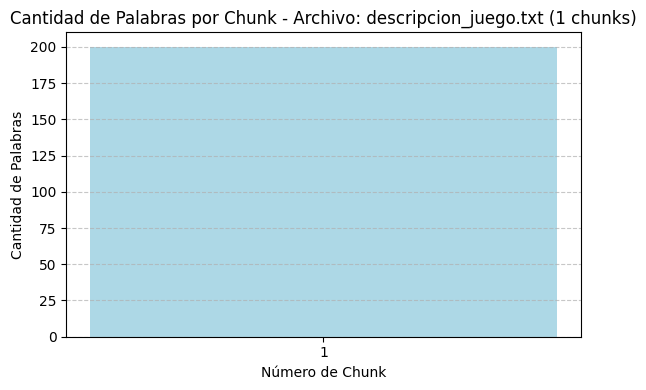


----------chunk: 1----------
descripcion_juego.txt
PARKS is a celebration of the US National Parks featuring illustrious art from Fifty-Nine Parks.
In PARKS, players will take on the role of two hikers as they trek through different trails across four seasons of the year. While on the trail, these hikers will take actions and collect memories of the places your hikers visit. These memories are represented by various resource tokens like mountains and forests. Collecting these memories in sets will allow players to trade them in to visit a National Park at the end of each hike.
Each trail represents one season of the year, and each season, the trails will change and grow steadily longer. The trails, represented by tiles, get shuffled in between each season and laid out anew for the next round. Resources can be tough to come by especially when someone is at the place you’re trying to reachPARKS! Campfires allow you to share a space and time with other hikers. Canteens and Gear can also 

In [ ]:
# splitter = Text_spliter(max_chunk_size=1024, min_chunk_size=2, embedding_model_name="Qwen/Qwen3-Embedding-0.6B")
# chunks, origenes_chunks = splitter.split_text(datos_informacion,nombre_archivos)

In [ ]:
# embeddings = splitter.get_embeddings(chunks)

In [ ]:
# len(chunks)

563

In [ ]:
# import pickle
# import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')
# # Carpeta destino
# ruta_carpeta = '/content/drive/MyDrive/Colab Notebooks/PLN/tp2/chunks'
# os.makedirs(ruta_carpeta, exist_ok=True)

# # Guardar embeddings
# np.save(os.path.join(ruta_carpeta, 'embeddings.npy'), embeddings)

# # Guardar chunks y orígenes
# with open(os.path.join(ruta_carpeta, 'chunks_y_origenes.pkl'), 'wb') as f:
#     pickle.dump({
#         'chunks': chunks,
#         'origenes_chunks': origenes_chunks
#     }, f)

# print("Archivos guardados correctamente.")

Mounted at /content/drive
Archivos guardados correctamente.


In [3]:
import numpy as np
import pandas as pd
# 2. Descargar archivos desde Google Drive
!gdown 1ZPNXd9vlGEUcsMDvB4TiRJder02Bg_Q8 -O chunks_y_origenes.pkl
!gdown 1SLt8dw_jL3GL6wYvSg0twA-j5gnh7U9c -O embeddings.npy

# 3. Cargar variables
import pickle

# Cargar chunks y orígenes
with open('chunks_y_origenes.pkl', 'rb') as f:
    chunks = pickle.load(f)

# Cargar
chunks = pd.DataFrame(chunks)
chunks.columns = ["chunk_text","archivo_origen"]
embeddings_chunks = np.load('embeddings.npy')
chunks['embedding'] = embeddings_chunks.tolist()
print("Todo cargado correctamente.")

Downloading...
From: https://drive.google.com/uc?id=1ZPNXd9vlGEUcsMDvB4TiRJder02Bg_Q8
To: /content/chunks_y_origenes.pkl
100% 1.03M/1.03M [00:00<00:00, 10.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SLt8dw_jL3GL6wYvSg0twA-j5gnh7U9c
To: /content/embeddings.npy
100% 2.31M/2.31M [00:00<00:00, 18.7MB/s]
Todo cargado correctamente.


In [4]:
!pip install langdetect --quiet
from langdetect import detect

def detectar_idioma_en_carpeta(textos:list[str], nombre_archivos:list[str])->pd.DataFrame:
  idioma_archivos = []
  for texto, nombre_archivo in zip(textos, nombre_archivos):
    idioma = detect(texto)
    idioma_archivos.append({
        "archivo": os.path.basename(nombre_archivo),
        "idioma": idioma
    })
  # Crear DataFrame
  df_idioma_archivos = pd.DataFrame(idioma_archivos)
  return df_idioma_archivos

df_idioma_archivos = detectar_idioma_en_carpeta(datos_informacion,nombre_archivos)
chunks['idioma'] = chunks['archivo_origen'].map(df_idioma_archivos.set_index('archivo')['idioma'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
# Añadimos una columna con la longitud del texto
chunks['longitud'] = chunks['chunk_text'].str.len()

# Ordenamos por longitud, de menor a mayor
chunks_ordenados = chunks.sort_values(by='longitud').reset_index(drop=True)

# Mostrar solo el texto ordenado (o también puedes mostrar otras columnas que te interesen)
chunks_ordenados[['chunk_text', 'longitud']].head(120)

,chunk_text,longitud
0,Many thanks!,12
1,\nYes indeed!,12
2,See here:\n\n,12
3,\nFrom page 8:\n,14
4,2. Yes\n3. Yep\n,14
...,...,...
115,I saw the the post on the official keymasterga...,547
116,Just curious if anyone sees a sale on this. I ...,576
117,I'll also add whenever someone draws a gear/ca...,577
118,Thanks fto everyone who chimed in here and fo...,583


Se observa que los chunks que tienen un tamaño menor a 500 caracteres no aportan ningun valor debido a que son oraciones muy aisladas y sin información relevante del juego por lo que se decide descartarlos.

In [6]:
chunks_filtrados = chunks[chunks['chunk_text'].str.len() >= 500].copy()
chunks_filtrados['chunk_id'] = range(len(chunks_filtrados))

In [7]:
print(len(chunks_filtrados))
chunks_filtrados.head(3)

455


,chunk_text,archivo_origen,embedding,idioma,longitud,chunk_id
0,PARKSes un diseño en el que los jugadores repr...,texto_misutmeeple_mecanica.txt,"[0.08277954906225204, -0.03400087356567383, -0...",es,4092,0
1,2. Se mezcla el mazo de cartas de parques y se...,texto_misutmeeple_mecanica.txt,"[0.06358643621206284, -0.039666224271059036, -...",es,1614,1
2,- Se aplica el patrón de fichas de agua y sol ...,texto_misutmeeple_mecanica.txt,"[0.10776355117559433, -0.025305192917585373, -...",es,3725,2


## Base de datos vectorial

In [8]:
# importo chromadb y creo client
!pip install chromadb --quiet
import chromadb

client = chromadb.Client()
chroma_collection = client.create_collection("park",
    configuration={
        "hnsw": {
            "space": "cosine"
        }
    }
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 9.9 MB/s e

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [9]:
# Convertir pandas.Series a listas
ids_list = chunks_filtrados["chunk_id"].astype(str).tolist()
embeddings_list = chunks_filtrados["embedding"].tolist()
documentos = chunks_filtrados["chunk_text"].tolist()
# Crear la lista de metadatos, un dict por chunk
metadatas_list = [
    {
        "origen": row["archivo_origen"],
        "tema": "reglas" if any(palabra in row["archivo_origen"].lower() for palabra in ["rules", "reglas"])
                else "review" if "review" in row["archivo_origen"].lower()
                else "guia",
        "tipo": "video" if "video" in row["archivo_origen"].lower() else "foro",
        "idioma": row["idioma"]
    }
    for _, row in chunks_filtrados.iterrows()
]

# Añadir a ChromaDB
chroma_collection.add(
    ids=ids_list,
    documents=documentos,
    embeddings=embeddings_list,
    metadatas=metadatas_list
)

print("Datos añadidos a ChromaDB correctamente.")

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionAddEvent: capture() takes 1 positional argument but 3 were given


Datos añadidos a ChromaDB correctamente.


In [10]:
from sentence_transformers import SentenceTransformer
from chromadb import Collection

class Vector_db:
  """
  Clase para interactuar con la base de datos vectorial ChromaDB
  utilizando el modelo embedding "Qwen/Qwen3-Embedding-0.6B" para realizar búsquedas semánticas.
  """
  def __init__(self, chroma_collection: Collection, modelo: SentenceTransformer):
    self._collection = chroma_collection
    self._modelo = modelo

  def _embed(self, query: str)-> np.ndarray:
    embeddings = self._modelo.encode(query)
    return embeddings

  def search(self, query:str, max_results:int = 3, filtros:dict[str,str] = None)->dict:
    """
    Realiza una búsqueda de similitud vectorial en la colección de ChromaDB.
    Permite filtrar los resultados basándose en metadatos.

    Args:
      query (str): La consulta de texto a buscar.
      max_results (int, optional): El número máximo de resultados a devolver. Por defecto es 3.
      filtros (dict[str, str], optional): Un diccionario de pares clave-valor
                                         para filtrar los metadatos de los documentos.
                                         Por ejemplo: {"tema": "guia", "idioma": "es"}.
                                         Por defecto es None (sin filtros).

    Returns:
      dict: Un diccionario que contiene los IDs, documentos, metadatos y puntuaciones
            (distancias) de los resultados de la búsqueda.
            Ejemplo de estructura:
            {
                "ids": ["id1", "id2"],
                "documents": ["documento1", "documento2"],
                "metadatas": [{"tema": "guia", "search_method": "vector_db"}, {"tema": "noticia", "search_method": "vector_db"}],
                "scores": [0.1, 0.2]
            }
    """
    # filter = {
        # "$and": [
        #     {"tema": "guia"},
        #     {"idioma": "es"},
        #     {"tipo": "foro"},
        #     {"origen": "reviews_videos_es_2.txt"},
        # ]
    # }
    filter = None
    if filtros:
      filter = {
      }
      filter["$and"].extend(filtros.items())

    embedding_query = self._embed(query).tolist()

    results = self._collection.query(
        query_embeddings=embedding_query,
        n_results=max_results,
        where=filter,
        include=["documents", "distances", "metadatas"],
    )

    # Fallback si no hay resultados
    if not results["documents"]:
        results = self._collection.query(
            query_embeddings=embedding_query,
            n_results=max_results,
            include=["documents", "distances", "metadatas"],
        )

    metadatas = [{**metadata,"search_method": "vector_db"} for metadata in results["metadatas"][0]]
    return {
            "ids": results["ids"][0],
            "documents": results["documents"][0],
            "metadatas": metadatas,
            "scores": results["distances"][0],
        }

Para las búsquedas en esta base de datos vectorial, es crucial utilizar el mismo modelo de embedding con el que se generaron los embeddings de los chunks almacenados. Esto asegura una total consistencia en cómo se representan tanto la consulta como los datos, garantizando que las comparaciones de similitud vectorial sean válidas y significativas dentro del mismo espacio vectorial.

In [11]:
modelo_embedding = SentenceTransformer("Qwen/Qwen3-Embedding-0.6B")
vector_db = Vector_db(chroma_collection, modelo_embedding)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [13]:
vector_db_output = vector_db.search("Que piezas trae el juego Parks?")
vector_db_output

{'ids': ['277', '11', '341'],
 'documents': ['hola hola pues el día de hoy les vamos a enseñar este hermoso juego que se llama parks es un juego de 1 a 5 jugadores y realmente aunque dice que tarda de 40 a 70 minutos yo creo que tarda como más o menos una media hora ya cuando tienes experiencia la primera partida mejor si te va a tomar unos 50 minutos tal vez pero ya después se ve muy muy ag es un juego muy bonito muy fácil de explicar y muy fácil de entender muy fácil de jugar obviamente y aunque lo juego dos veces ese juego me gustó muchísimo tenemos la expansión y esta se la voy a explicar en otro vídeo hoy no vamos a consultar únicamente en el juego base bien pues realmente la primera parte del set op es básicamente esta área del aborto y básicamente lo único que hay que hacer es pues hay que revolver los parqués y mostramos tres vamos a revolver las cartas de equipo y vamos a mostrar tres vamos a revolver las cartas de temporadas o de xixón y vamos a revelar una y vamos a revolver

## BM25 search

In [14]:
!pip install txtai --quiet
from txtai.scoring import ScoringFactory
from txtai.embeddings import Documents

class BM25Searcher:
    """ Clase para realizar búsquedas de texto utilizando el algoritmo BM25 (Best Match 25)"""
    def __init__(self, chroma_collection: Collection):
        self._collection = chroma_collection
        self._scoring = ScoringFactory.create({"method": "bm25", "terms": True})
        self._documents = {}  # Almacena id -> texto
        self._metadatas = {}  # Almacena id -> metadatos
        self._load_docs()

    def _load_docs(self)->None:
        """Carga todos los documentos de ChromaDB para BM25."""
        data = self._collection.get(include=["documents", "metadatas"])

        # Preparar documentos en formato [(id, text, None), ...]
        documents = []
        for doc_id, text, metadata in zip(data["ids"], data["documents"], data["metadatas"]):
            documents.append((doc_id, text, None))  # Formato txtai
            self._documents[doc_id] = text
            self._metadatas[doc_id] = metadata

        # Indexar los documentos
        self._scoring.index(documents)

    def search(self, query: str, max_results: int = 3)->dict:
        """
        Busca usando BM25 y devuelve los documentos más relevantes.

        Args:
            query: Consulta de búsqueda
            max_results: Número máximo de resultados a devolver

        Returns:
            Diccionario con:
            - ids: Lista de IDs
            - documents: Lista de textos
            - metadatas: Lista de metadatos
            - scores: Lista de puntuaciones
        """
        # Los resultados son tuplas (id, score)
        results = self._scoring.search(query, max_results)

        ids = [r[0] for r in results]
        scores = [r[1] for r in results]
        documents = [self._documents[doc_id] for doc_id in ids]
        metadatas = [{**self._metadatas[doc_id],"search_method": "bm25"} for doc_id in ids]
        return {
            "ids": ids,
            "documents": documents,
            "metadatas": metadatas,
            "scores": scores,
        }

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.6/267.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.4 MB/s eta 0:00:00


In [15]:
bm25_searcher = BM25Searcher(chroma_collection)
bm25_output = bm25_searcher.search("Que piezas trae el juego Parks?")
bm25_output

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given


{'ids': ['256', '257', '252'],
 'documents': [' es un año en que nuestros senderistas pues en un sendero durante una hora y van a visitar estos parques entonces probaremos cuatro cartas de estar durante todo el juego esta es la primera y la marcamos la dejamos aquí boca arriba para representar que es la primera estación a continuación vamos a montar lo que es el sendero el sendero lo montaremos en cada estación incluyendo la primera para montar el sendero vamos a las piezas del sendero aquí entonces hay dos tipos de piezas valen y en grande estas son las piezas básicas porque abajo a la derecha tienen el icono es ceder o una flecha a una casa y aquí tiene un asterisco entonces las que tienen a este disco con las piezas avanzadas y las que no tienen las tres cosas piezas básica entonces esta de aquí sólo se usa cuando somos 4 o más jugadores no se ve muy bien en él el simulador pero esto es un 4 más para partidas de menos de 4 jugadores no la vamos a la dejamos por aquí y lo que haremos

## Reranker

Para el reranker se decidio utilizar el [modelo "BAAI/bge-reranker-v2-m3"](https://huggingface.co/BAAI/bge-reranker-v2-m3) debido a que es el modelo de reranker mas liviano que soporta chunks de texto de hasta 1024 tokens (que es la maxima cantidad de nuetros chunks)

In [16]:
# Primero instalamos la biblioteca necesaria
!pip install FlagEmbedding --quiet

# Importamos la librería
from FlagEmbedding import FlagReranker

class Reranker:
  """
  Clase para realizar el re-ranking de una lista de documentos basándose en su relevancia
  respecto a una consulta dada.
  """
  def __init__(self, reranker_model_name: str ='BAAI/bge-reranker-v2-m3' ):
    self._reranker = FlagReranker(reranker_model_name, use_fp16=True)

  def compute_scores(self, query: str, docs: list[str]) -> list[float]:
        pairs = [[query, doc] for doc in docs]
        scores = self._reranker.compute_score(pairs)
        return scores

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.1/866.1 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [17]:
reranker = Reranker()
documents = bm25_output["documents"] + vector_db_output["documents"]
reranker_output = reranker.compute_scores("Que piezas trae el juego Parks?", documents)
reranker_output

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


[-1.978515625,
 -5.97265625,
 0.285400390625,
 -0.0572509765625,
 -5.0234375,
 -0.86474609375]

## Hybrid search

In [18]:
from collections import OrderedDict
class Hybrid_search:
  """
  Clase que implementa una estrategia de búsqueda híbrida combinando
  búsqueda vectorial (semántica), búsqueda BM25 (basada en palabras clave)
  y un paso final de re-ranking.
  """
  def __init__(self, vector_db: Vector_db, bm25_searcher: BM25Searcher, reranker: Reranker):
    self._vector_db = vector_db
    self._bm25_searcher = bm25_searcher
    self._reranker = reranker

  def search(self, query: str, max_results: int = 3,filters:dict = None):
    # Obtener resultados iniciales
    vector_result = self._vector_db.search(query, max_results * 2, filtros=filters)
    bm25_result = self._bm25_searcher.search(query, max_results * 2)

    # Combinar resultados evitando duplicados por ID
    seen_ids = set()
    combined_documents = OrderedDict()

    for result in [vector_result, bm25_result]:
        for i in range(len(result['ids'])):
            doc_id = result['ids'][i]
            if doc_id not in seen_ids:
                seen_ids.add(doc_id)
                combined_documents[doc_id] = {
                    'document': result['documents'][i],
                    'metadata': result['metadatas'][i],
                    'score': result['scores'][i]
                }
            else:
                combined_documents[doc_id]["metadata"]['search_method'] = "bm25 + vector_db"
    # Preparar documentos para reranking
    doc_texts = [combined_documents[doc_id]['document'] for doc_id in combined_documents]
    # Aplicar reranking
    rerank_scores = self._reranker.compute_scores(query, doc_texts)

    # Emparejar IDs con sus nuevos scores
    reranked = []
    for idx, doc_id in enumerate(combined_documents):
        reranked.append({
            'id': doc_id,
            'document': combined_documents[doc_id]['document'],
            'metadata': combined_documents[doc_id]['metadata'],
            'rerank_score': float(rerank_scores[idx])
         })

    # Ordenar por rerank_score descendente
    reranked.sort(key=lambda x: x['rerank_score'], reverse=True)

    # Devolver top-N resultados en formato compatible
    top_n = reranked[:max_results]
    return {
         "ids": [item['id'] for item in top_n],
         "documents": [item['document'] for item in top_n],
         "metadatas": [item['metadata'] for item in top_n],
        "scores": [item['rerank_score'] for item in top_n],
    }
hybrid_search = Hybrid_search(vector_db, bm25_searcher, reranker)

Se obtienen los “max_results * 2” documentos más relevantes de cada método (vectorial y BM25). Luego, se combinan, eliminando duplicados por “chunk_id” y marcando el “search_method” para cada documento por si es necesario debugear los documentos extraidos de cada base de datos. Finalmente, se envían todos los documentos combinados al re-ranker, que produce un nuevo score de relevancia. Los documentos se ordenan por este “rerank_score” y se devuelven los “max_results” principales.

In [19]:
hybrid_output = hybrid_search.search("Que piezas trae el juego Parks?", max_results=5)
hybrid_output

{'ids': ['367', '302', '252', '277', '311'],
 'documents': ['hola bienvenidos al canal hoy os traemos parks un juego de colección de sets y colocación de trabajadores que utiliza un tablero modular fue diseñado por henry audubon e ilustrado por fifty nine park sprint series el juego fue publicado por primera vez en 2019 por key master games mientras que la versión en español corre a cargo de trans games en parks los jugadores se convierten en excursionistas cuyo objetivo es tener la mayor cantidad de puntos que obtendrán visitando parques haciendo fotos y cumpliendo los objetivos personales es un juego de 1 a 5 jugadores está recomendado para mayores de 10 años y tiene una duración de entre 30 y 60 minutos por partida vamos a ver de qué trata este parque si ya conoces parks y quieres descubrir su expansión consulta nuestro vídeo de nightfall donde te explicamos las nuevas mecánicas y cambios respecto al juego original vamos ya con la preparación de la partida primero habrá que colocar 

## LLM

Para el modelo de lenguaje se eligio "gemini-2.5-flash-preview-05-20" por tener acceso gratuito para la cantidad de usos que necesita este proyecto, no requiere utilizar recursos computacionales propios, es rapido y logra generar respuestas precisas incluso ante la complejidad de las distintas queries.

In [20]:
from google import genai

class LLMModel:
  """
  Clase para interactuar con un modelo de lenguaje natural (LLM) a través
  de la API de Google Generative AI (genai).

  Esta clase encapsula la configuración del modelo y el proceso de generación
  de texto, permitiendo enviar prompts y recibir las respuestas del LLM.
  """
  def __init__(self, api_key:str, model_name:str):
    self._model_name = model_name
    self._client = genai.Client(api_key= api_key)

  def generate(self, prompt:str)->str:
    response = self._client.models.generate_content(model=self._model_name, contents=[prompt])
    return response.text

In [21]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
model_name = "gemini-2.5-flash-preview-05-20"
llm = LLMModel(GOOGLE_API_KEY, model_name)

## Base de datos tabular

In [22]:
stats = pd.read_csv("datos/estadisticas/stats.csv")
stats

,Título,Descripción
0,Avg. Rating,7.646
1,No. of Ratings,"28,119"
2,Std. Deviation,1.22
3,Weight,2.12/ 5
4,Comments,"4,245"
5,Fans,"2,437"
6,Page Views,"1,760,603"
7,Overall Rank,157Historical Rank
8,Family Rank,25Historical Rank
9,All Time Plays,"98,797"


Se observa que la información del dataframe es en formato titulo-descripcion por lo que se decide pivotear el dataframe para poder acceder a la información de forma mas directa

In [23]:
import unicodedata

# Paso 1: Transponer y establecer nueva cabecera
stats_pivot = stats.transpose()
stats_pivot.columns = stats_pivot.iloc[0]
stats_pivot = stats_pivot.drop(stats_pivot.index[0])

# Paso 2: Función para limpiar nombres de columnas
def limpiar_nombre(col):
    # Convertir a cadena por si acaso
    col = str(col)
    # Eliminar acentos
    col = ''.join(
        c for c in unicodedata.normalize('NFD', col)
        if unicodedata.category(c) != 'Mn'
    )
    # Pasar a minúsculas
    col = col.lower()
    # Eliminar puntos
    col = col.replace('.', '')
    # Reemplazar espacios por guiones bajos
    col = col.replace(' ', '_')
    return col

# Paso 3: Aplicar la limpieza a las columnas
stats_pivot.columns = [limpiar_nombre(col) for col in stats_pivot.columns]

numeric_cols = [
    'avg_rating', 'no_of_ratings', 'std_deviation',
    'comments', 'fans', 'page_views', 'all_time_plays',
    'this_month', 'own', 'prev_owned', 'wishlist',
    'has_parts', 'want_parts'
]

for col in numeric_cols:
    stats_pivot[col] = pd.to_numeric(stats_pivot[col].str.replace(',', '').str.split('/').str[0], errors='coerce')

# Paso 4: Mostrar resultado
stats_pivot.head()

,avg_rating,no_of_ratings,std_deviation,weight,comments,fans,page_views,overall_rank,family_rank,all_time_plays,this_month,own,prev_owned,for_trade,want_in_trade,wishlist,has_parts,want_parts
Descripción,7.646,28119,1.22,2.12/ 5,4245,2437,1760603,157Historical Rank,25Historical Rank,98797,29,49971,2778,381Find For-Trade Matches,807Find Want-in-Trade Matches,10388,14,10


In [24]:
PROMPT_TABULAR_DB = """
Eres un asistente especializado en transformar consultas en lenguaje natural a código de pandas en Python para responder preguntas sobre el juego Parks.

Dado el siguiente DataFrame 'df', cuya estructura es:

{estructura}

Y la consulta del usuario es:

"{query}"

Tu tarea es:
1. Interpretar correctamente la intención del usuario.
2. Generar **únicamente** el código de pandas necesario para ejecutar dicha consulta.
3. Asegurarte de que el código haga uso de la variable `df` ya definida.
4. No incluyas instrucciones adicionales, comentarios ni asignaciones extra (como `resultado = ...`). Solo el código que se puede ejecutar directamente para mostrar el resultado.
5. Si la consulta implica operaciones complejas, desglosa paso a paso lo necesario, pero mantén el output limpio y listo para imprimir o mostrar.
6. En caso de que la consulta no se pueda responder con el DataFrame, responde con "None".

Ejemplo de buen formato de salida:
df[["avg_rating","no_of_ratings"]]

Ahora responde únicamente con el código de pandas correspondiente a la consulta dada.
"""
class Tabular_db:
  """
  Clase para interactuar con datos tabulares (representados por un DataFrame de Pandas)
  utilizando un Modelo LLM para interpretar consultas en lenguaje natural
  y generar código Python para operar sobre el DataFrame.

  Su objetivo principal es permitir a los usuarios consultar datos tabulares
  sin necesidad de escribir código directamente, traduciendo sus preguntas
  a operaciones de Pandas.
  """
  def __init__(self, stats: pd.DataFrame, llm:LLMModel,prompt_base: str):
    self._stats = stats
    self._llm = llm
    self.prompt_base = prompt_base
    self._estructura = {
                'columnas': self._stats.columns.tolist(),
                'tipos': self._stats.dtypes.astype(str).to_dict(),
                'cantidad_filas': len(self._stats),
                'cantidad_columnas': self._stats.shape[1],
            }

  def search(self, query:str)-> str:
    df = self._stats
    prompt = self.prompt_base.format(estructura = self._estructura, query = query)
    code = self._llm.generate(prompt)
    if code == "None":
      return "La consulta no se puede responder con el DataFrame. reformule su pregunta"
    try:
      response = eval(code)
      return str(response)
    except Exception as e:
      print(f"Error al evaluar el código: {e}")
      return "La consulta no se puede responder con el DataFrame. reformule su pregunta"

In [25]:
tabular_db = Tabular_db(stats_pivot, llm, PROMPT_TABULAR_DB)

In [ ]:
consultas = [
    "Muestra la calificación promedio y la cantidad de ratings del juego",
    "¿Cuántos usuarios poseen físicamente el juego? Muestra solo ese número",
    "Show the number of page views and the overall rank",
    "Cual es el clima en Argentina?"
]
for consulta in consultas:
  print(consulta)
  print(tabular_db.search(consulta))
  print("-"*50)

Muestra la calificación promedio y la cantidad de ratings del juego
             avg_rating  no_of_ratings
Descripción       7.646          28119
--------------------------------------------------
¿Cuántos usuarios poseen físicamente el juego? Muestra solo ese número
49971
--------------------------------------------------
Show the number of page views and the overall rank
             page_views        overall_rank
Descripción     1760603  157Historical Rank
--------------------------------------------------
Cual es el clima en Argentina?
La consulta no se puede responder con el DataFrame. reformule su pregunta
--------------------------------------------------


## Base de grafos

### Knowledge graph

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22283 (\N{CJK UNIFIED IDEOGRAPH-570B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20844 (\N{CJK UNIFIED IDEOGRAPH-516C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22290 (\N{CJK UNIFIED IDEOGRAPH-5712}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figu

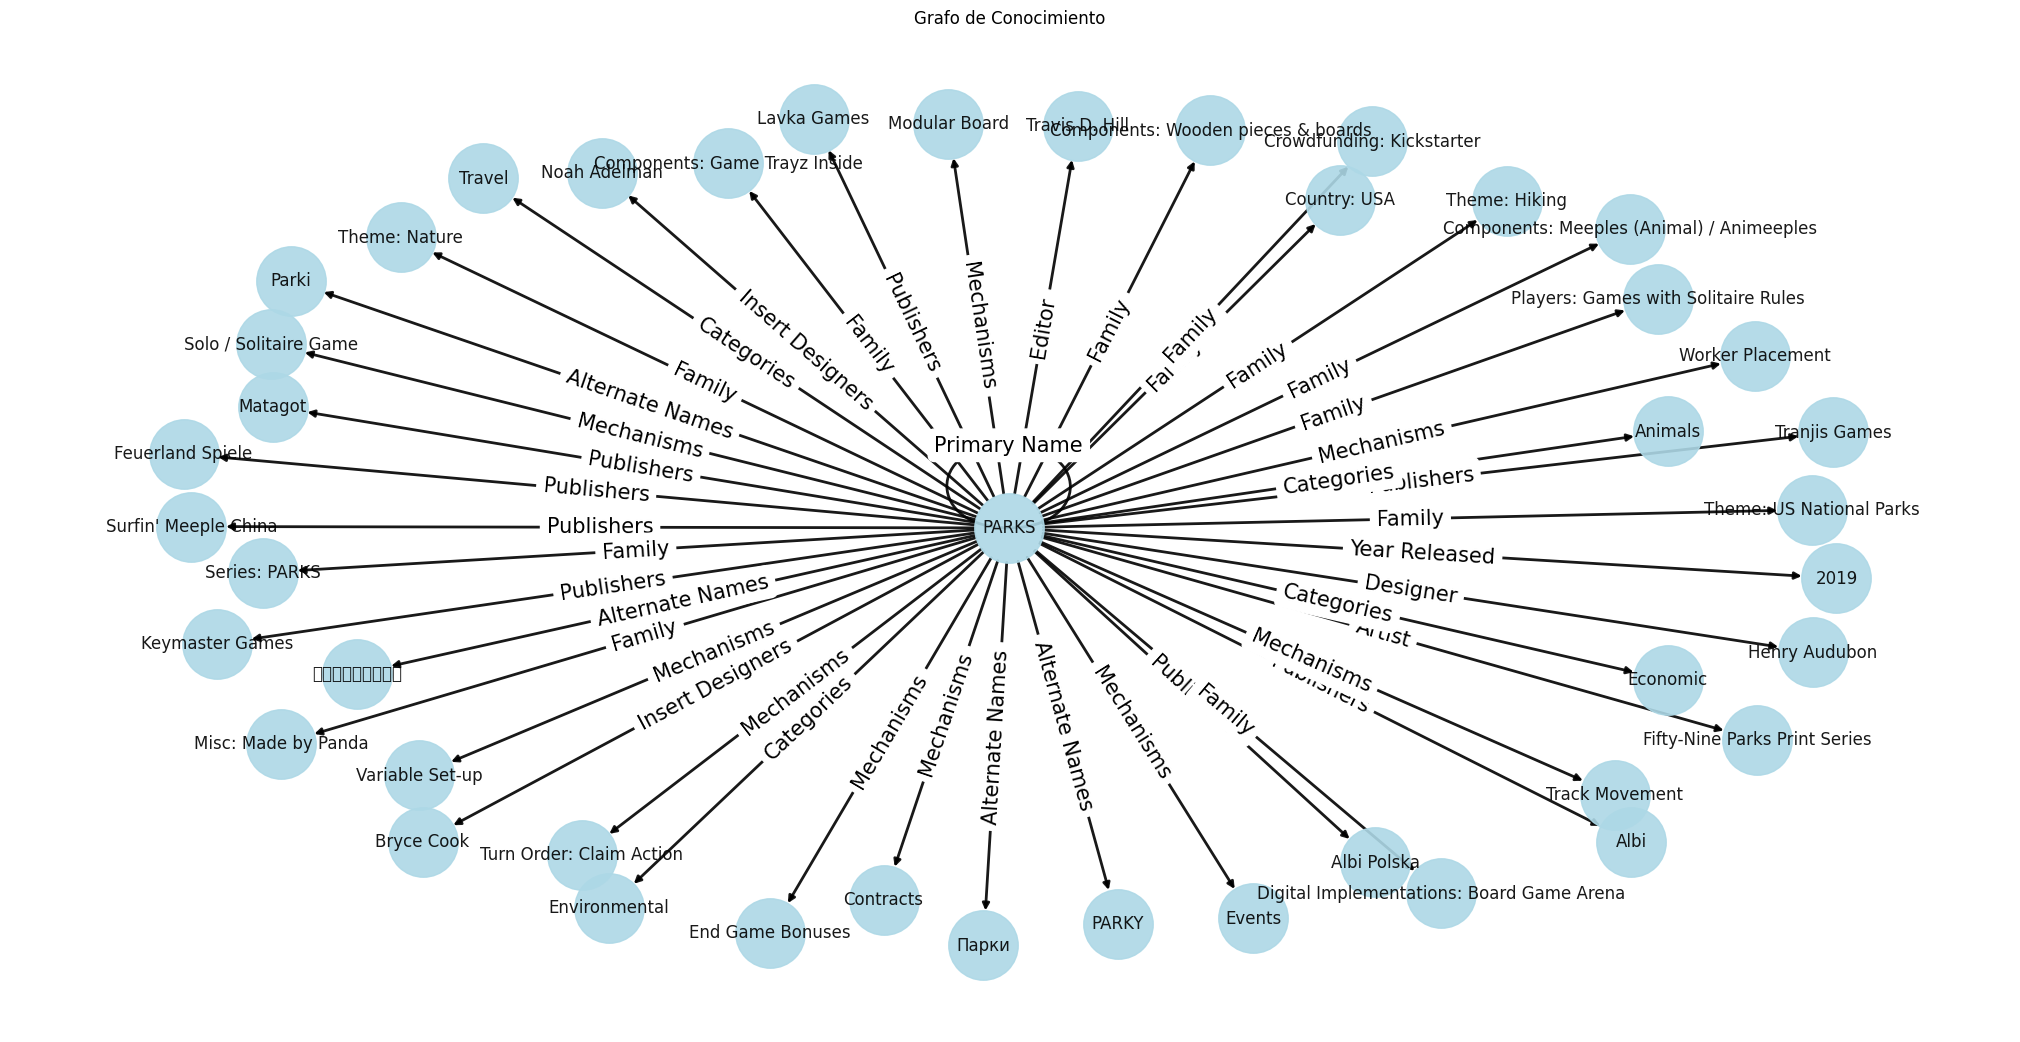

In [26]:
!pip install networkx --quiet
import networkx as nx
import matplotlib.pyplot as plt

relaciones = pd.read_csv("datos/relaciones/relaciones_parks.csv")

# Crear un grafo dirigido
G = nx.DiGraph()

# Diccionario para almacenar las etiquetas de las aristas (relaciones)
edge_labels = {}

for relacion in relaciones.itertuples():
  G.add_edge(relacion[1], relacion[3])
  edge_labels[(relacion[1], relacion[3])] = relacion[2]

plt.figure(figsize=(20, 10))

# Aumentar el espacio entre nodos
pos = nx.spring_layout(G, k=0.5)

nx.draw(G, pos, edge_color='black', width=2.0, linewidths=1,
        node_size=2500, node_color='lightblue', alpha=0.9,
        labels={node: node for node in G.nodes()})
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15)
plt.title('Grafo de Conocimiento')
plt.axis('off')
plt.show()

Se observa que todas las relacion son directas con el juego Parks

### reddis graph

In [27]:
!pip install redis redisgraph --quiet
!wget http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!curl -fsSL https://packages.redis.io/redis-stack/redis-stack-server-6.2.6-v7.focal.x86_64.tar.gz -o redis-stack-server.tar.gz
!tar -xvf redis-stack-server.tar.gz
!./redis-stack-server-6.2.6-v7/bin/redis-stack-server --daemonize yes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 11.2 MB/s eta 0:00:00
--2025-06-29 17:08:35--  http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
Resolving nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)... 91.189.91.81, 91.189.91.82, 185.125.190.82, ...
Connecting to nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)|91.189.91.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318204 (1.3M) [application/vnd.debian.binary-package]
Saving to: ‘libssl1.1_1.1.1f-1ubuntu2_amd64.deb’

libssl1.1_1.1.1f-1u 100%[===================>]   1.26M  2.39MB/s    in 0.5s    

2025-06-29 17:08:36 (2.39 MB/s) - ‘libssl1.1_1.1.1f-1ubuntu2_amd64.deb’ saved [1318204/1318204]

Selecting previously unselected package libssl1.1:amd64.
(Reading database ... 126308 files and directories currently installed.)
Preparing to unpack libssl1.1_1.1.1f-1ubuntu2_amd64.d

In [28]:
import redis
from redisgraph import Graph, Node, Edge
import re
# Función para sanitizar nombres (eliminar caracteres problemáticos)
def sanitize_name(name):
    # Eliminar caracteres problemáticos
    name = re.sub(r'[^a-zA-Z0-9_]',"", name)
    if name is None:
        return "None"
    if not isinstance(name, str):
        name = str(name)
    return name

# Conexión a Redis
redis_client = redis.Redis(host='localhost', port=6379)

# Nombre de tu grafo en Redis
graph_name = 'knowledge_graph_parks'
graph = Graph(graph_name, redis_client)

# Diccionario para mantener referencia a los nodos ya creados
created_nodes = {}

# Procesar cada relación del grafo NetworkX
for relacion in relaciones.itertuples():

  source = relacion[1]
  target = relacion[3]
  relationship_type = sanitize_name(relacion[2])

  # Crear nodo origen si no existe
  if source not in created_nodes:
      created_nodes[source] = Node(label='Entity', properties={'name': source})
      graph.add_node(created_nodes[source])

  # Crear nodo destino si no existe
  if target not in created_nodes:
      created_nodes[target] = Node(label='Entity', properties={'name': target})
      graph.add_node(created_nodes[target])

  # Crear la relación
  edge = Edge(created_nodes[source], relationship_type, created_nodes[target])
  graph.add_edge(edge)


# Guardar los datos en RedisGraph
graph.commit()


# Ejemplo de consulta para verificar los datos
query = """MATCH (s)-[r]->(t) RETURN s.name, type(r), t.name"""

result = graph.query(query)
graph_relaciones = set()
print("Relaciones en el grafo:")
for record in result.result_set:
  graph_relaciones.add(record[1])
  print(f"{record[0]} --{record[1]}--> {record[2]}")


Relaciones en el grafo:
PARKS --PrimaryName--> PARKS
PARKS --AlternateNames--> Parki
PARKS --AlternateNames--> PARKY
PARKS --AlternateNames--> Парки
PARKS --AlternateNames--> 國家公園：自然之旅
PARKS --YearReleased--> 2019
PARKS --Designer--> Henry Audubon
PARKS --Artist--> Fifty-Nine Parks Print Series
PARKS --Publishers--> Keymaster Games
PARKS --Publishers--> Albi
PARKS --Publishers--> Albi Polska
PARKS --Publishers--> Feuerland Spiele
PARKS --Publishers--> Lavka Games
PARKS --Publishers--> Matagot
PARKS --Publishers--> Surfin' Meeple China
PARKS --Publishers--> Tranjis Games
PARKS --Editor--> Travis D. Hill
PARKS --InsertDesigners--> Noah Adelman
PARKS --InsertDesigners--> Bryce Cook
PARKS --Categories--> Animals
PARKS --Categories--> Economic
PARKS --Categories--> Environmental
PARKS --Categories--> Travel
PARKS --Mechanisms--> Contracts
PARKS --Mechanisms--> End Game Bonuses
PARKS --Mechanisms--> Events
PARKS --Mechanisms--> Modular Board
PARKS --Mechanisms--> Solo / Solitaire Game
PARKS 

In [29]:
graph_relaciones

{'AlternateNames',
 'Artist',
 'Categories',
 'Designer',
 'Editor',
 'Family',
 'InsertDesigners',
 'Mechanisms',
 'PrimaryName',
 'Publishers',
 'YearReleased'}

Se observa que hay 11 posible relaciones entre Parks y los distintos nodos.

### Graph_db

In [30]:
PROMPT_GRAPH_DB_RELATIONS = """
Eres un asistente especializado en transformar consultas en lenguaje natural a relaciones semánticas representables en una base de grafos.

Dado el siguiente esquema conceptual:
- Los nodos representan entidades como 'PARKS' y otras relacionadas.
- Las relaciones posibles son:
  AlternateNames, Artist, Categories, Designer, Editor,
  Family, InsertDesigners, Mechanisms, PrimaryName, Publishers, YearReleased

Tu tarea es:
1. Interpretar la intención del usuario desde la consulta dada.
2. Identificar **todas las relaciones relevantes** (de las listadas) que conectan 'PARKS' con otra entidad según la consulta.
3. Devolver **únicamente** las relaciones encontradas, separadas por "|".
4. Si no hay ninguna relación aplicable, responde únicamente con "None".

Ejemplo:
consulta: Quienes son los diseñadores de este juego?
respuesta:Designer|InsertDesigners

Consulta del usuario:
"{query}"

Responde únicamente con las relaciones correspondientes (separadas por |) o 'None'.
"""

class Graph_db:
  """
  Clase para interactuar con una base de datos de grafos, utilizando un Modelo LLM
  para traducir consultas en lenguaje natural a consultas Cypher (o el lenguaje de consulta del grafo)
  y ejecutar esas consultas.

  Esta implementación específica está diseñada para buscar relaciones entre entidades en el grafo,
  donde el LLM ayuda a identificar el tipo de relación relevante para la consulta del usuario.
  """
  def __init__(self, graph:Graph, llm:LLMModel, prompt_base:str):
    self._graph = graph
    self._llm = llm
    self.query_db = """MATCH (s:Entity {{name: 'PARKS'}})-[r:{relation}]->(t:Entity) RETURN s.name, type(r), t.name"""
    self.prompt_base = prompt_base

  def search(self, query:str)-> str:
    relation = self._llm.generate(self.prompt_base.format(query = query))
    if relation == "None":
      return "La consulta no se puede responder con esta base de grafos. Reformule su pregunta"

    cypher_query = self.query_db.format(relation = relation)
    results = self._graph.query(cypher_query)

    if not results:
      return "La consulta no se puede responder con esta base de grafos. Reformule su pregunta"

    response = ""
    for record in results.result_set:
        source, rel_type, target = record
        response += f"{source} --{rel_type}--> {target}\n"
    return response

In [31]:
graph_db = Graph_db(graph, llm, PROMPT_GRAPH_DB_RELATIONS)

In [ ]:
consultas_graph = ["Quienes fueron los diseñadores de Parks?","¿Quién publicó PARKS?","¿A qué familia de juegos pertenece PARKS?","¿que dias es hoy?"]
for consulta in consultas_graph:
  print(consulta)
  print(graph_db.search(consulta))
  print("-"*50)

Quienes fueron los diseñadores de Parks?
PARKS --Designer--> Henry Audubon
PARKS --InsertDesigners--> Noah Adelman
PARKS --InsertDesigners--> Bryce Cook

--------------------------------------------------
¿Quién publicó PARKS?
PARKS --Publishers--> Keymaster Games
PARKS --Publishers--> Albi
PARKS --Publishers--> Albi Polska
PARKS --Publishers--> Feuerland Spiele
PARKS --Publishers--> Lavka Games
PARKS --Publishers--> Matagot
PARKS --Publishers--> Surfin' Meeple China
PARKS --Publishers--> Tranjis Games

--------------------------------------------------
¿A qué familia de juegos pertenece PARKS?
PARKS --Family--> Components: Game Trayz Inside
PARKS --Family--> Components: Meeples (Animal) / Animeeples
PARKS --Family--> Components: Wooden pieces & boards
PARKS --Family--> Country: USA
PARKS --Family--> Crowdfunding: Kickstarter
PARKS --Family--> Digital Implementations: Board Game Arena
PARKS --Family--> Misc: Made by Panda
PARKS --Family--> Players: Games with Solitaire Rules
PARKS --Fa

## Clasificador de intencion

Se decidió armar el clasificador de intención utilizando una LLM con Few-Shot Prompting, a diferencia del modelo entrenado en el punto 6 del TP1P2. Esta elección se debe a que la LLM ofrece resultados correctos de manera consistente, un factor crítico para la fiabilidad del sistema. El modelo anterior mostraba una mayor inconsistencia, especialmente cuando la consulta no estaba directamente relacionada con el juego, pero compartía una estructura similar a las categorías definidas. Por ejemplo, ante una consulta como '¿Cuál es la cantidad de habitantes de París?', el modelo entrenado erróneamente respondía 'tabular_db'.

En contraste, la LLM logra clasificar correctamente este tipo de consultas, derivando a 'None' o la categoría adecuada. Dado que este clasificador es una parte fundamental del pipeline de nuestro Chatbot, una decisión errónea aquí tendría un impacto significativo: el retriever buscaría información en la base de datos incorrecta, resultando en respuestas erróneas o la ausencia total de respuesta. Por lo tanto, se priorizó la mayor precisión y robustez de la LLM para esta etapa crucial.

In [32]:
clasificador_prompt ="""Eres un sistema de clasificación de intenciones de busqueda del juego Parks. Tu tarea es analizar preguntas y determinar a qué categoría pertenecen: "doc_db" , "graph_db" , "tabular_db" , o "None" . A continuación, se describen las características de cada categoría:

"graph_db" : Las preguntas están relacionadas con relaciones entre entidades del juego Parks (por ejemplo, publicadores, artistas, familias temáticas,categorias,mechanisms). Generalmente implican nombre de personas.
"tabular_db" : Las preguntas buscan información cuantitativa o estadística sobre el juego Parks. Suelen referirse a datos numéricos o métricas.
"doc_db" : Las preguntas tratan sobre descripciones detalladas, críticas, mecánicas o comparaciones subjetivas de un tema del juego Parks. Están relacionadas con análisis cualitativos o descriptivos.
"None" : Las preguntas no están relacionadas con ninguna de las categorías anteriores ni con el juego Parks. Pueden ser sobre temas generales, triviales o fuera del ámbito de los datos específicos.
A continuación, te proporciono ejemplos para ilustrar cada categoría:

Ejemplos de "graph_db":
Pregunta : ¿El juego PARKS es parte de la familia 'Theme: US National Parks'?
Respuesta : graph_db
Pregunta : Fifty-Nine Parks Print Series está asociado con qué juego como artista?
Respuesta : graph_db
Pregunta : ¿Matagot es uno de los publicadores de PARKS?
Respuesta : graph_db
Ejemplos de "tabular_db":
Pregunta : ¿Cuál es la dificultad de PARKS?
Respuesta : tabular_db
Pregunta : ¿Aproximadamente cuántas personas tienen PARKS?
Respuesta : tabular_db
Pregunta : ¿El juego PARKS tiene una calificación promedio de 7.646?
Respuesta : tabular_db
Ejemplos de "doc_db":
Pregunta : ¿Qué tipo de componentes destacan en la producción del juego PARKS?
Respuesta : doc_db
Pregunta : ¿Cómo se obtienen la mayoría de los puntos en PARKS?
Respuesta : doc_db
Pregunta : ¿Qué crítica principal se hace sobre la jugabilidad de PARKS?
Respuesta : doc_db
Ejemplos de "None":
Pregunta : ¿Cuál es la capital de Estonia?
Respuesta : None
Pregunta : ¿Qué ingredientes lleva una auténtica paella valenciana?
Respuesta : None
Pregunta : ¿Quién escribió la novela "Cien años de soledad"?
Respuesta : None
Ahora, clasifica la siguiente pregunta:

Pregunta : {query}
Respuesta :"""
class ClasificadorIntencion:
  """
  Clase para clasificar la intención de una consulta de usuario,
  dirigiéndola a la base de datos más apropiada (documental, de grafos, tabular)
  o marcándola como "None" si no es relevante.

  Utiliza un LLM configurado con un prompt específico
  para realizar esta tarea de clasificación.
  """
  def __init__(self, llm:LLMModel, prompt_base:str):
    self._llm = llm
    self.prompt_base = prompt_base
  def clasificar(self,query:str)->str:
    prompt = self.prompt_base.format(query=query)
    respuesta =  self._llm.generate(prompt)
    return respuesta

In [33]:
clasificador_intencion = ClasificadorIntencion(llm, clasificador_prompt)

## Retrieval

In [34]:
class Retrieval:
  """
  Clase que orquesta el proceso de recuperación de información basado en la intención de la consulta
  del usuario. Actúa como el "cerebro" central del sistema de recuperación, decidiendo
  qué base de datos o motor de búsqueda especializado debe usarse para responder una pregunta.

  Utiliza un clasificador de intención para dirigir la consulta a la fuente de datos
  más apropiada (base de grafos, base de datos tabular o bases de documentos)
  y luego formatea la respuesta.
  """
  def __init__(self, graph_db:Graph_db, tabular_db:Tabular_db, hybrid_search:Hybrid_search, clasificador_intencion:ClasificadorIntencion):
    self._graph_db = graph_db
    self._tabular_db = tabular_db
    self._hybrid_search = hybrid_search
    self._clasificador_intencion = clasificador_intencion

  def retrieve(self, query:str, max_results:int = 3)->str:
    db_query = self._clasificador_intencion.clasificar(query)
    if db_query == "graph_db":
      return "graph_db:\n" + self._graph_db.search(query)
    elif db_query == "tabular_db":
      return "tabular_db: " + self._tabular_db.search(query)
    elif db_query == "doc_db":
      value = self._hybrid_search.search(query, max_results)
      response = "doc_db:\n"
      for item, metadata in zip(value["documents"],value["metadatas"]):
        response += f"Documento {metadata['origen']}: {item}\n"
      return response
    else:
      return "Su pregunta no esta relacionada con el juego Parks"

In [35]:
retrieval = Retrieval(graph_db, tabular_db, hybrid_search, clasificador_intencion)

In [37]:
consultas = ["¿Qué relación tiene el juego PARKS con Bryce Cook?", # graph_db
             "¿El juego PARKS ha sido calificado por más de 10,000 usuarios en BoardGameGeek?",# tabular_db
             "¿Qué diferencia hay entre las mecánicas del juego base PARKS y las de la expansion Nightfall?", # doc_db
             "¿Cuál es la población actual de Islandia?",# None
             "¿Quienes son lo publicadores de PARKS y en que año se estreno el juego?", # graph_db
              "¿Me podrias explicar por que cuando una persona tira los dados y sale 1 tres veces pierde un turno?"] # doc_db
for consulta in consultas:
  print(consulta)
  print(retrieval.retrieve(consulta))
  print("-"*50)

¿Qué relación tiene el juego PARKS con Bryce Cook?
graph_db:
PARKS --Designer--> Henry Audubon
PARKS --Artist--> Fifty-Nine Parks Print Series
PARKS --Publishers--> Keymaster Games
PARKS --Publishers--> Albi
PARKS --Publishers--> Albi Polska
PARKS --Publishers--> Feuerland Spiele
PARKS --Publishers--> Lavka Games
PARKS --Publishers--> Matagot
PARKS --Publishers--> Surfin' Meeple China
PARKS --Publishers--> Tranjis Games
PARKS --Editor--> Travis D. Hill
PARKS --InsertDesigners--> Noah Adelman
PARKS --InsertDesigners--> Bryce Cook

--------------------------------------------------
¿El juego PARKS ha sido calificado por más de 10,000 usuarios en BoardGameGeek?
tabular_db: True
--------------------------------------------------
¿Qué diferencia hay entre las mecánicas del juego base PARKS y las de la expansion Nightfall?
doc_db:
Documento reviews_videos_es_4.txt: hola bienvenidos al canal hoy os traemos parks un juego de colección de sets y colocación de trabajadores que utiliza un tablero

## Chatbot

In [38]:
!pip install colorama --quiet
from colorama import Fore, Style, init

# Inicializar colorama
init(autoreset=True)

PROMPT_CHATBOT = """
Historial de conversación:
{history}

Eres un chatbot especializado en responder preguntas sobre el juego de mesa **Parks**.
Tu objetivo es ayudar a los jugadores a entender las reglas, estrategias y mecánicas del juego.

Vas a recibir contexto de una de las tres diferentes base de datos:
"graph_db": Esta base de datos te va a dar contexto en formato Entidad --Relacion--> Entidad
"tabular_db": Esta base de datos te va a dar contexto en formato pandas dataframe en formato string, puede contener datos numéricos
y no numéricos, en algunos caso puede ser un valor booleano ya respondiendo una consulta especifica del usuario
"doc_db": Esta base de datos te va a dar contexto en formato de documentos
Tu trabajo es interpretar este contexto para poder responder la pregunta del usuario.

Contexto: {contexto}

Pregunta del usuario: {query}

Instrucciones:
1. Interpertar el contexto
2. Si el contexto proporciona información suficiente para responder la pregunta, utiliza esa información para formular una respuesta clara y concisa.
3. Si el contexto no es suficiente o no hay información relevante, pide al usuario que reformule su pregunta para que sea más específica.
4. Si la pregunta no está relacionada con el juego **Parks**, recuérdale al usuario que este chatbot está especializado en ese tema y que reformule su pregunta.
5. Es obligatorio que la respuesta sea en el mismo idioma que la pregunta del usuario.

Respuesta:
"""
class ChatBotParks:
    """
    Clase que implementa un Chatbot conversacional para el juego Parks.
    Combina un Modelo de Lenguaje natural (LLM) con un sistema de recuperación
    de información para generar respuestas informadas a las consultas de los usuarios.

    El chatbot mantiene un historial de conversación para permitir un diálogo contextual.
    """
    def __init__(self, llm:LLMModel, retrieval:Retrieval, prompt_base: str):
        self._llm = llm
        self._retrieval = retrieval
        self.prompt_base = prompt_base
        self.history = []

    def chat(self, query: str)-> str:
        contexto = self._retrieval.retrieve(query)
        prompt = self.prompt_base.format(query=query, contexto=contexto, history=self.history)
        response = self._llm.generate(prompt)
        self.history.append({"query": prompt, "response": response})
        return response

    def reset(self)-> None:
        self.history = []

    def conversacion(self)-> None:
        print(Fore.CYAN + "Bienvenido al chatbot. Escribe 'q' para salir en cualquier momento.")
        while True:
            # Solicitar entrada del usuario
            user_input = input(Fore.BLUE + "Tú: " + Style.RESET_ALL)

            # Verificar si el usuario quiere salir
            if user_input.strip().lower() == "q":
                print("Chatbot: Hasta luego. ¡Espero verte pronto!")
                self.reset()  # Resetear el historial
                break

            # Procesar la entrada del usuario
            response = self.chat(user_input)
            print(f"Chatbot: {response}")


In [39]:
chatbot = ChatBotParks(llm, retrieval, PROMPT_CHATBOT)

In [40]:
consultas = ["¿Qué relación tiene el juego PARKS con Bryce Cook?", # Busqueda de persona en graph_db
             "¿El juego PARKS ha sido calificado por más de 10,000 usuarios en BoardGameGeek?",# Busqueda de datos en tabular_db
             "¿Qué diferencia hay entre las mecánicas del juego base PARKS y las de la expansion Nightfall?", # Busqueda de informacion en doc_db
             "¿Cuál es la población actual de Islandia?",# Pregunta no relacionada con el juego
             "¿Quienes son lo publicadores de PARKS y en que año se estreno el juego?", #Busqueda de compleja en graph_db
              "¿Me podrias explicar por que cuando una persona tira los dados y sale 1 tres veces pierde un turno?"]# Busqueda de informacion inexistente en doc_db

In [41]:
chatbot.conversacion()

Bienvenido al chatbot. Escribe 'q' para salir en cualquier momento.
Tú: ¿Qué relación tiene el juego PARKS con Bryce Cook?
Chatbot: Según la información proporcionada, Bryce Cook es uno de los diseñadores de los insertos del juego PARKS.
Tú: ¿El juego PARKS ha sido calificado por más de 10,000 usuarios en BoardGameGeek?
Chatbot: Sí, según la información proporcionada, el juego PARKS ha sido calificado por más de 10,000 usuarios en BoardGameGeek.
Tú: ¿Qué diferencia hay entre las mecánicas del juego base PARKS y las de la expansion Nightfall?
Chatbot: Según la información proporcionada, la expansión Nightfall introduce las siguientes mecánicas y cambios en el juego PARKS:

1.  **Nuevas cartas de Parque:** Incluyen nuevas recompensas y arte inédito de la serie Fifty-Nine Parks Print.
2.  **Nuevas cartas de Año:** Ofrecen nuevas oportunidades de puntuación de bonificación.
3.  **Nueva mecánica de Acampada (Camping):** Permite experimentar el sendero de una forma completamente nueva.
Tú: ¿

## Agente ReAct

In [ ]:
!pip3 install duckduckgo_search wikipedia --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.4 MB/s eta 0:00:00


In [ ]:
import wikipedia
from duckduckgo_search import DDGS
import logging

# Configuración del Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

class Tools:
    """
    Clase que encapsula un conjunto de herramientas de búsqueda y recuperación de información.
    Estas herramientas pueden ser utilizadas por un agente para acceder
    a diferentes fuentes de datos, como bases de datos internas (grafos, tabular, documentos)
    y fuentes externas (Wikipedia, DuckDuckGo).

    Proporciona métodos específicos para cada tipo de búsqueda, actuando como una interfaz
    unificada para la recuperación de datos.
    """

    def __init__(self, graph_db:Graph_db, tabular_db:Tabular_db, hybrid_search:Hybrid_search):
        self._graph_db = graph_db
        self._tabular_db = tabular_db
        self._hybrid_search = hybrid_search

    def graph_search(self, query: str) -> str:
        """Realiza consultas dinámicas a la base de datos de grafos."""
        return self._graph_db.search(query)

    def table_search(self, query: str) -> str:
        """Realiza consultas dinámicas a los datos tabulares."""
        return self._tabular_db.search(query)

    def doc_search(self, query: str, max_results: int = 3) -> str:
        """Busca en los documentos de texto usando búsqueda híbrida y re-rank."""
        value = self._hybrid_search.search(query, max_results)
        response = "doc_db:\n"
        for item, metadata in zip(value["documents"],value["metadatas"]):
          response += f"Documento {metadata['origen']}: {item}\n"
        return response

    def wikipedia_search(self, query: str) -> str:
        """Busca información en Wikipedia."""
        try:
            wikipedia.set_lang('en')
            result = wikipedia.page(query, auto_suggest=True).content

            return result
        except Exception as e:
            return f"Error en Wikipedia: {e}"

    def duckduckgo_search(self, query: str) -> str:
        """Realiza búsquedas en internet usando DuckDuckGo."""
        try:
            results = DDGS().text(query, max_results=3)
            if results:
                response = "duckduckgo_search:\n"
                for result in results:
                    response += f"{result['title']}: {result['body']}\n"
                return response
            return "No se encontraron resultados en DuckDuckGo."
        except Exception as e:
            return f"Error en DuckDuckGo: {e}"

In [ ]:
system_prompt = """Eres un asistente especializado en el juego de mesa **Parks** que responde en el idioma de la consulta y sigue reglas de manera muy estricta. Tu objetivo es responder a las preguntas del usuario utilizando un conjunto de herramientas disponibles.

**REGLAS OBLIGATORIAS:**

1. **PROCESO `Thought -> Action -> Observation`**: Debes seguir este ciclo. NO PUEDES dar una `Final Answer` hasta que hayas recogido TODA la información necesaria excepto que la consulta este fuera de contexto en ese caso es importante que respondas con "Final Answer: respuesta...".
2. **UNA HERRAMIENTA A LA VEZ**: En cada paso, solo puedes usar UNA herramienta.
3. **PREGUNTAS COMPUESTAS**: Si la pregunta del usuario tiene varias partes (p. ej., "¿Cómo funciona el sistema de estaciones y qué significan los iconos?"), DEBES usar las herramientas una por una.
   - Primero, `Thought` sobre la primera parte y usa la herramienta.
   - Después de la `Observation`, `Thought` sobre la segunda parte y usa la otra herramienta.
   - SOLO cuando tengas todas las observaciones, podrás generar la `Final Answer`.
4. **FORMATO `Action`**: El `Action` DEBE SER SIEMPRE un STR, ES OBLIGATORIO QUE ESTE EN FORMATO ´Action: doc_search("query")´, Action no debe llevar nunca tilde.
   - Si la herramienta requiere argumentos (como `graph_search`), el formato es "término a buscar".
5. **NO INVENTES RESPUESTAS**: Si la información puede ser obtenida por una herramienta, DEBES usar la herramienta. No inventes reglas, estrategias o mecánicas del juego.
6. **VERIFICACIÓN FINAL**: Antes de dar la `Final Answer`, revisa la pregunta original del usuario y asegúrate de haber respondido a TODAS las partes y asegúrate de que tu respuesta este en el mismo idioma que la consulta del usuario.
7. **ENFOQUE TEMÁTICO**: Si la pregunta no está relacionada con el juego **Parks**, recuérdale al usuario que este chatbot está especializado en ese tema.

**HERRAMIENTAS DISPONIBLES:**
- `graph_search`: Para consultas sobre relaciones entre elementos del juego (formato Entidad --Relación--> Entidad)
- `table_search`: Las preguntas buscan información cuantitativa o estadística sobre el juego Parks. Suelen referirse a datos numéricos o métricas.ej: ranking, rating, peso, etc.
- `doc_search`: Para información detallada en documentos de texto (máx. 3 resultados)
- `wikipedia_search`: SOLO para información general sobre el juego/ cuando doc_search() falle
- `duckduckgo_search`: SOLO como último recurso para información no encontrada en las otras bases (graph_search() y table_search()), usualmente es informacion actual como fechas

**EJEMPLO DE PREGUNTA COMPUESTA:**
User: ¿Cuales son las reglas mas importantes en Parks y a qué tipos de familia de juegos pertece Parks?

Thought: El usuario tiene dos preguntas. Primero, buscaré información sobre el sistema de reservas en las bases de datos del juego.
Action: doc_search("Reglas mas importantes en Parks")
Observation: [Reglas mas importantes en Parks]

Thought: Ya tengo la información sobre reservas. Ahora buscaré sobre los tipos de familia de juegos que pertece Parks.
Action: graph_search("tipos de familia de juegos que pertece Parks")
Observation: [Relaciones de tipos de parques desde la base de grafos]
Thought: Ahora tengo toda la información necesaria para responder ambas preguntas.
Final Answer: El sistema de reservas funciona... Existen los siguientes tipos de familia de juegos que pertece Parks:...

User: ¿Que hora es en Alemania?
Thought: No puedo responder a preguntas fuera del contexto de Parks.
Observation: No puedo responder a preguntas fuera del contexto de Parks.
Final Answer: Este chatbot está especializado en el juego de mesa Parks. No puedo responer a preguntas fuera de este contexto. Por favor, reformule su pregunta
ENFASIS EN EL ´Final Answer: ´ esta parte no puede faltar y es fundamental en una respuesta


**INSTRUCCIONES ADICIONALES:**
1. Prioriza siempre las bases de datos especializadas (graph_db, tabular_db, doc_db) sobre Wikipedia o DuckDuckGo.
2. Para preguntas sobre reglas específicas, mecanicas, guias o intrucciones, usa primero `doc_search`.
3. Para preguntas sobre información cuantitativa o estadística sobre el juego Parks, usa `graph_search`. Suelen referirse a datos numéricos o métricas.
4. Para preguntas que están relacionadas con relaciones entre entidades del juego Parks (por ejemplo, publicadores, artistas, familias temáticas,categorias,mechanisms). Generalmente implican nombres, usa `graph_search`.
5. Solo usa herramientas externas (Wikipedia/DuckDuckGo) para información general sobre el juego que no encuentres en las bases especializadas o informacion actual.
6. Si el contexto proporcionado por las herramientas no es suficiente, pide al usuario que reformule su pregunta de manera más específica.
7. IMPORTANTE, LA ´Final Answer:´ DEBE OBLIGATORIAMENTE ESTAR EN EL MISMO IDIOMA DE LA CONSULTA DEL USUARIO.
8. Si la pregunta no esta relacionada con el juego no te olvides te terminar la conversacion con `Final Answer: ` y una explicacion"""


In [ ]:
class AgenteParks:
    """
    Clase que implementa un agente conversacional basado en el patrón ReAct
    (Reasoning and Acting). Este agente es capaz de razonar sobre una consulta
    del usuario, decidir qué herramientas utilizar para obtener información,
    ejecutar esas herramientas y luego sintetizar una respuesta final.

    El agente interactúa con un LLM para la toma de decisiones y con un conjunto
    de herramientas para acceder a diversas fuentes de datos.
    """
    def __init__(self, graph_db: Graph_db, tabular_db: Tabular_db, hybrid_search: Hybrid_search, llm: LLMModel, system_pompt:str):
        self.tools = Tools(graph_db, tabular_db, hybrid_search)
        self.llm = llm
        self.system_prompt = system_prompt

    def validar_y_extraer_accion(self, linea_accion: str) -> tuple[bool, str, str]:
        """Valida el formato 'herramienta("parametro")' y extrae sus componentes."""
        try:
            linea_limpia = linea_accion.strip()
            if '(' not in linea_limpia or ')' not in linea_limpia:
                return False, "", ""
            nombre_herramienta = linea_limpia.split('(')[0].strip()
            inicio_param = linea_limpia.find('(') + 1
            fin_param = linea_limpia.rfind(')')
            parametro_bruto = linea_limpia[inicio_param:fin_param]
            parametro = parametro_bruto.strip().strip('"\'')
            return True, nombre_herramienta, parametro
        except Exception as e:
            logger.error(f"Error validando acción: {e}")
            return False, "", ""

    def ejecutar_accion(self, nombre_herramienta: str, parametro: str) -> str:
        """Ejecuta la herramienta correspondiente y devuelve el resultado."""
        try:
            if nombre_herramienta == 'graph_search':
                return self.tools.graph_search(parametro)
            elif nombre_herramienta == 'table_search':
                return self.tools.table_search(parametro)
            elif nombre_herramienta == 'doc_search':
                return self.tools.doc_search(parametro)
            elif nombre_herramienta == 'wikipedia_search':
                return self.tools.wikipedia_search(parametro)
            elif nombre_herramienta == 'duckduckgo_search':
                return self.tools.duckduckgo_search(parametro)
            return "Error: Herramienta no reconocida."
        except Exception as e:
            logger.error(f"Error ejecutando la herramienta {nombre_herramienta}: {e}")
            return f"Error al ejecutar la herramienta: {e}"

    def procesar_respuesta_llm(self, respuesta_llm: str) -> tuple[str, bool]:
        """Procesa la respuesta del LLM y ejecuta la acción correspondiente."""
        paso_actual_str = []
        terminado = False
        thought = None
        action = None
        final_answer = None

        lineas = respuesta_llm.strip().split('\n')
        for linea in lineas:
            linea = linea.strip()
            if not linea:
                continue
            linea_lower = linea.lower()
            if linea_lower.startswith("thought:"):
                thought = linea
            elif linea_lower.startswith("action:"):
                action = linea
            elif linea_lower.startswith("final answer:") or linea_lower.startswith("answer:"):
                final_answer = linea
                terminado = True
                break

        if thought:
            paso_actual_str.append(thought)
        if action and not terminado:
            paso_actual_str.append(action)
            accion_contenido = action[7:].strip()  # Remover "Action: "
            es_valida, nombre, param = self.validar_y_extraer_accion(accion_contenido)
            if es_valida:
                observacion = self.ejecutar_accion(nombre, param)
                paso_actual_str.append(f"Observation: {observacion}")
            else:
                paso_actual_str.append("Observation: Error en el formato de la acción.")
        if final_answer:
            paso_actual_str.append(final_answer)

        return "\n".join(paso_actual_str), terminado

    def generar_respuesta_llm(self, mensajes: list[dict]) -> str:
        """Genera una respuesta usando el modelo LLM de Google GenAI."""
        try:
            # Convertir el historial de mensajes a un formato compatible con la API de Google GenAI
            prompt = "\n".join([f"{msg['role']}: {msg['content']}" for msg in mensajes])
            response = self.llm.generate(prompt)
            return response
        except Exception as e:
            logger.error(f"Error al generar respuesta con el LLM: {e}")
            return "Error: No se pudo generar una respuesta."

    def responder_pregunta(self, query: str, max_iteraciones: int = 15) -> str:
        mensajes = [
            {'role': 'system', 'content': self.system_prompt},
            {'role': 'user', 'content': f"Pregunta: {query}"}
        ]
        historial_completo = []

        print("\n" + "="*50)
        print(f"Iniciando proceso para pregunta: {query}")
        print("="*50 + "\n")

        for iteracion in range(max_iteraciones):
            print(f"\n=== ITERACIÓN {iteracion + 1} ===")

            # Generar respuesta del LLM
            respuesta_llm = self.generar_respuesta_llm(mensajes)
            print("\n[LLM]:")
            print(respuesta_llm)

            historial_completo.append(f"Iteración {iteracion + 1}:\n{respuesta_llm}")

            # Verificar formato ReAct
            if "Action:" not in respuesta_llm:
                if "Final Answer:" in respuesta_llm:
                    print("\n[RESPUESTA FINAL ENCONTRADA]")
                    print(respuesta_llm.split("Final Answer:")[1].strip())
                    return respuesta_llm.split("Final Answer:")[1].strip()

                mensajes.append({'role': 'assistant', 'content': respuesta_llm})
                mensajes.append({'role': 'user', 'content': "ERROR: Debes usar el formato ReAct. Ejemplo:\nThought: [tu análisis]\nAction: herramienta('consulta')"})
                continue

            # Procesar acción
            action_line = next(line for line in respuesta_llm.split('\n') if "Action:" in line)
            action = action_line.split("Action:")[1].strip()
            print(f"\n[ACCION DETECTADA]: {action}")

            valid, tool, param = self.validar_y_extraer_accion(action)
            if not valid:
                print("[ERROR] Formato de acción inválido")
                mensajes.append({'role': 'assistant', 'content': respuesta_llm})
                mensajes.append({'role': 'user', 'content': f"ERROR: Acción inválida: {action}. Formato correcto: herramienta('parametro')"})
                continue

            # Ejecutar herramienta
            print(f"\n[EJECUTANDO HERRAMIENTA]: {tool}('{param}')")
            observation = self.ejecutar_accion(tool, param)
            print(f"[RESULTADO]: {observation}...")

            historial_completo.append(f"Ejecutando {tool}('{param}')\nObservation: {observation}")

            # Actualizar historial
            mensajes.append({'role': 'assistant', 'content': respuesta_llm})
            mensajes.append({'role': 'user', 'content': f"Observation: {observation}"})

            # Verificar si dio respuesta final
            if "Final Answer:" in respuesta_llm:
                final_answer = respuesta_llm.split("Final Answer:")[1].strip()
                print("\n[RESPUESTA FINAL ENCONTRADA]")
                print(final_answer)
                return final_answer

        print("\n[LÍMITE DE ITERACIONES ALCANZADO]")
        return "Lo siento, no pude encontrar una respuesta después de varias iteraciones."

In [ ]:
agente_parks = AgenteParks(graph_db, tabular_db, hybrid_search, llm, system_prompt)

### Testeo de agente

In [ ]:
response_1 = agente_parks.responder_pregunta("¿Quines son los publicadores del juego Parks y en que año lanzo su ultima expansion?")


Iniciando proceso para pregunta: ¿Quines son los publicadores del juego Parks y en que año lanzo su ultima expansion?


=== ITERACIÓN 1 ===

[LLM]:
Thought: El usuario tiene dos preguntas. Primero, buscaré quiénes son los publicadores del juego Parks usando `graph_search` ya que implica una relación entre el juego y sus publicadores.
Action: graph_search("publicadores del juego Parks")

[ACCION DETECTADA]: graph_search("publicadores del juego Parks")

[EJECUTANDO HERRAMIENTA]: graph_search('publicadores del juego Parks')
[RESULTADO]: PARKS --Publishers--> Keymaster Games
PARKS --Publishers--> Albi
PARKS --Publishers--> Albi Polska
PARKS --Publishers--> Feuerland Spiele
PARKS --Publishers--> Lavka Games
PARKS --Publishers--> Matagot
PARKS --Publishers--> Surfin' Meeple China
PARKS --Publishers--> Tranjis Games
...

=== ITERACIÓN 2 ===

[LLM]:
Thought: Ya tengo la información sobre los publicadores. Ahora necesito buscar en qué año se lanzó la última expansión del juego Parks. Esta es u

In [ ]:
# Query compleja graph_search para buscar los publicadores, doc_search() para buscar informacion sobre la expansion (nombre),
# wikipedia_search o duckduckgo_search para obtener la fecha de lanzamiento
print("¿Quines son los publicadores del juego Parks y en que año lanzo su ultima expansion?\n")
print(response_1)

¿Quines son los publicadores del juego Parks y en que año lanzo su ultima expansion?

Los publicadores del juego Parks son Keymaster Games, Albi, Albi Polska, Feuerland Spiele, Lavka Games, Matagot, Surfin' Meeple China y Tranjis Games. La expansión "Nightfall", que es la primera y, según la información disponible, la principal expansión mencionada, fue lanzada el 1 de enero de 2020.


In [ ]:
response_2 = agente_parks.responder_pregunta("¿Could you explain to me why when a person rolls the dice and gets 1 three times, they lose a turn??")


Iniciando proceso para pregunta: ¿Could you explain to me why when a person rolls the dice and gets 1 three times, they lose a turn??


=== ITERACIÓN 1 ===

[LLM]:
Thought: The user is asking about a specific game rule related to rolling dice and losing a turn. This type of information (game mechanics, rules) is typically found in documentation. Therefore, I should use `doc_search`.
Action: doc_search("lose a turn dice roll three times Parks")

[ACCION DETECTADA]: doc_search("lose a turn dice roll three times Parks")

[EJECUTANDO HERRAMIENTA]: doc_search('lose a turn dice roll three times Parks')
[RESULTADO]: doc_db:
Documento texto_foros_variants.txt: More Effective Gears
Nightfall "fixed" the Year End cards. As for "gear" cards we always play that they refresh each season. Not only does this keep it from stagnating (no one wants what is showing) it also adds a bit of pressure if you are considering a gear card as you know it will be gone with the change of seasons.
...What is creati

In [ ]:
## Query en ingles con busqueda doc_search donde se consulta informacion no existente en el juego
print("¿Could you explain to me why when a person rolls the dice and gets 1 three times, they lose a turn??\n")
print(response_2)

¿Could you explain to me why when a person rolls the dice and gets 1 three times, they lose a turn??

Based on the available documentation, there is no rule in the game Parks that states a player loses a turn for rolling a '1' three times with the dice. The provided texts discuss dice rolls for Ranger movement in variants or for refreshing cards, but not for losing a turn under those specific conditions.


In [ ]:
response_3 = agente_parks.responder_pregunta("¿Cuales son las reglas mas importantes en Parks y a qué tipos de familia de juegos pertece Parks?")


Iniciando proceso para pregunta: ¿Cuales son las reglas mas importantes en Parks y a qué tipos de familia de juegos pertece Parks?


=== ITERACIÓN 1 ===

[LLM]:
Thought: El usuario tiene dos preguntas. Primero, buscaré información sobre las reglas más importantes en Parks usando `doc_search`.
Action: doc_search("Reglas más importantes en Parks")

[ACCION DETECTADA]: doc_search("Reglas más importantes en Parks")

[EJECUTANDO HERRAMIENTA]: doc_search('Reglas más importantes en Parks')
[RESULTADO]: doc_db:
Documento htp_videos_es_5.txt: ir aquí y vamos a comprar el equipo no tenemos el descuento porque está ocupado pero tenemos muchos soles con lo cual no necesitamos un después entonces que tenemos aquí por ejemplo este de aquí parece bastante interesante porque nos dice que ganaremos agua en vez del árbol cuando visitemos esto de aquí esto de aquí corresponde con el bosque de aquí después la acción básica del bosque parece interesante porque ganaremos tres aguas esta nos permite visitar

In [ ]:
## Query compleja con busqueda doc_search y graph_search
print("¿Cuales son las reglas mas importantes en Parks y a qué tipos de familia de juegos pertece Parks?\n")
print(response_3)

¿Cuales son las reglas mas importantes en Parks y a qué tipos de familia de juegos pertece Parks?

Las reglas más importantes en Parks se centran en la acumulación de puntos de victoria al final de cuatro estaciones (un año), siendo la visita a los parques la principal fuente de estos puntos. Otras formas de obtener puntos incluyen tomar fotos (descartando fichas), poseer la ficha de jugador inicial (que otorga un punto de victoria), y cumplir con objetivos secretos de jugador. Las reglas son consideradas fáciles de aprender y bien explicadas en las losetas y cartas. Además, los efectos de las cartas de estación y los patrones climáticos pueden influir en la estrategia.

En cuanto a los tipos de familia de juegos a los que pertenece Parks, se relaciona con:
*   **Componentes:** Game Trayz Inside, Meeples (Animal) / Animeeples, Piezas y tableros de madera.
*   **País:** USA.
*   **Financiación:** Kickstarter (crowdfunding).
*   **Implementaciones Digitales:** Board Game Arena.
*   **Mis

In [ ]:
response_4 = agente_parks.responder_pregunta("¿Cual es la población actual de Islandia y cuantas personas juegan juegos de mesa?")


Iniciando proceso para pregunta: ¿Cual es la población actual de Islandia y cuantas personas juegan juegos de mesa?


=== ITERACIÓN 1 ===

[LLM]:
Este chatbot está especializado en el juego de mesa Parks. No puedo responder a preguntas fuera de este contexto. Por favor, reformule su pregunta.

=== ITERACIÓN 2 ===

[LLM]:
Este chatbot está especializado en el juego de mesa Parks. No puedo responder a preguntas fuera de este contexto. Por favor, reformule su pregunta.

=== ITERACIÓN 3 ===

[LLM]:
Thought: El usuario está haciendo una pregunta que no está relacionada con el juego de mesa Parks. Según las reglas, si la pregunta no está relacionada con el juego, debo informar al usuario que este chatbot está especializado en Parks y no puedo responder a preguntas fuera de este contexto. No es necesario usar ninguna herramienta ya que la pregunta está fuera de tema.
Final Answer: Este chatbot está especializado en el juego de mesa Parks. No puedo responder a preguntas fuera de este contexto

In [ ]:
# Query fuera del contexto del agente
print("¿Cual es la población actual de Islandia y cuantas personas juegan juegos de mesa?\n")
print(response_4)

¿Cual es la población actual de Islandia y cuantas personas juegan juegos de mesa?

Este chatbot está especializado en el juego de mesa Parks. No puedo responder a preguntas fuera de este contexto. Por favor, reformule su pregunta.


In [ ]:
response_5 = agente_parks.responder_pregunta("¿Cual es el ranking del juego Parks? ¿cual es su rating promedio? y ¿Cuanto pesa?")


Iniciando proceso para pregunta: ¿Cual es el ranking del juego Parks? ¿cual es su rating promedio? y ¿Cuanto pesa?


=== ITERACIÓN 1 ===

[LLM]:
Thought: El usuario está preguntando por el ranking, el rating promedio y el peso del juego Parks. Todas estas son preguntas sobre datos cuantitativos o estadísticos, por lo que la herramienta adecuada es `table_search`. Empezaré por el ranking.
Action: table_search("ranking del juego Parks")

[ACCION DETECTADA]: table_search("ranking del juego Parks")

[EJECUTANDO HERRAMIENTA]: table_search('ranking del juego Parks')
[RESULTADO]:                    overall_rank        family_rank
Descripción  157Historical Rank  25Historical Rank...

=== ITERACIÓN 2 ===

[LLM]:
Thought: Ya obtuve el ranking. Ahora necesito el rating promedio. Seguiré usando `table_search` para esta información.
Action: table_search("rating promedio del juego Parks")

[ACCION DETECTADA]: table_search("rating promedio del juego Parks")

[EJECUTANDO HERRAMIENTA]: table_search('

In [ ]:
# Query compleja que require de tres busquedas en tabular_search
print("¿Cual es el ranking del juego Parks? ¿cual es su rating promedio? y ¿Cuanto pesa?\n")
print(response_5)

¿Cual es el ranking del juego Parks? ¿cual es su rating promedio? y ¿Cuanto pesa?

El ranking general del juego Parks es 157 y su ranking familiar es 25. El rating promedio del juego es 7.646. El peso del juego es de 2.12/5.
